In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM, Dense
import seaborn as sns

In [2]:
df = pd.read_csv('Final.csv')

In [3]:
df.set_index('Date', inplace=True)

In [4]:
df.index = pd.to_datetime(df.index)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7308 entries, 2001-01-01 to 2021-12-01
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   provincename        7308 non-null   object 
 1   Construction        7308 non-null   float64
 2   Transportation      7308 non-null   float64
 3   Agriculture         7308 non-null   float64
 4   Population          7308 non-null   int64  
 5   Station Name        7308 non-null   object 
 6   Max Temp (°C)       7308 non-null   float64
 7   Total Snow (cm)     7308 non-null   float64
 8   Total Precip (mm)   7308 non-null   float64
 9   Min Temp (°C)       7308 non-null   float64
 10  MeanTemp            7308 non-null   float64
 11  Heat Deg Days (°C)  7308 non-null   float64
 12  Cool Deg Days (°C)  7308 non-null   float64
 13  Longitude (x)       7308 non-null   float64
 14  Latitude (y)        7308 non-null   float64
dtypes: float64(12), int64(1), object(2)
m

# EDA

In [6]:
df.describe()

,Construction,Transportation,Agriculture,Population,Max Temp (°C),Total Snow (cm),Total Precip (mm),Min Temp (°C),MeanTemp,Heat Deg Days (°C),Cool Deg Days (°C),Longitude (x),Latitude (y)
count,7308.000000,7308.000000,7308.000000,7.308000e+03,7308.000000,7308.000000,7308.000000,7308.000000,7308.000000,7308.000000,7308.00000,7308.000000,7308.000000
mean,505.598713,263.011712,931.009654,8.236259e+04,10.083016,1.052239,1.053708,-2.852477,3.619433,14.605667,0.22510,-113.416897,51.855862
std,1753.427334,930.069180,3332.585625,2.763412e+05,12.580190,1.058683,3.136251,11.347364,11.715353,11.391951,0.96725,2.039470,1.768942
min,0.000000,0.761174,0.000000,1.050000e+02,-29.300000,0.000000,0.000000,-41.600000,-32.900000,0.000000,0.00000,-119.400000,49.120000
25%,10.492333,3.711166,19.218472,2.465000e+03,1.400000,0.312500,0.000000,-10.000000,-4.225000,4.800000,0.00000,-114.440000,50.050000
50%,21.035169,11.398235,67.985580,4.590000e+03,10.800000,0.754545,0.000000,-1.300000,4.900000,13.100000,0.00000,-113.520000,52.070000
75%,59.498895,30.688435,235.445675,8.330000e+03,20.400000,1.457031,0.700000,6.100000,13.200000,22.225000,0.00000,-112.050000,53.140000
max,11518.343640,5935.071255,24029.514950,1.239220e+06,39.500000,9.465758,50.600000,23.400000,29.300000,50.900000,11.30000,-110.070000,55.200000


In [7]:
unique_station_names = df['Station Name'].unique()
productivity_columns = ['Construction',  'Transportation', 'Agriculture']


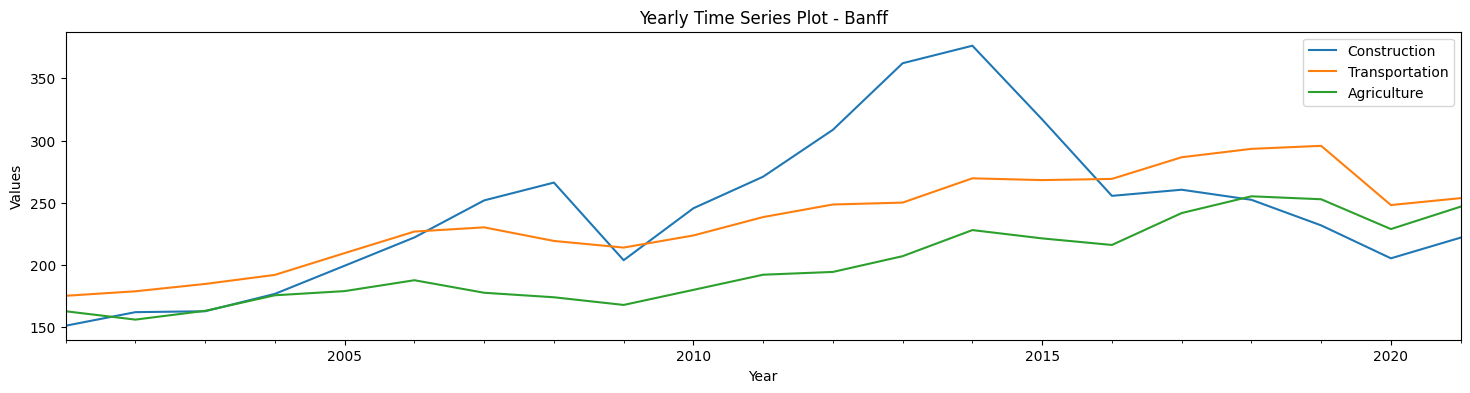

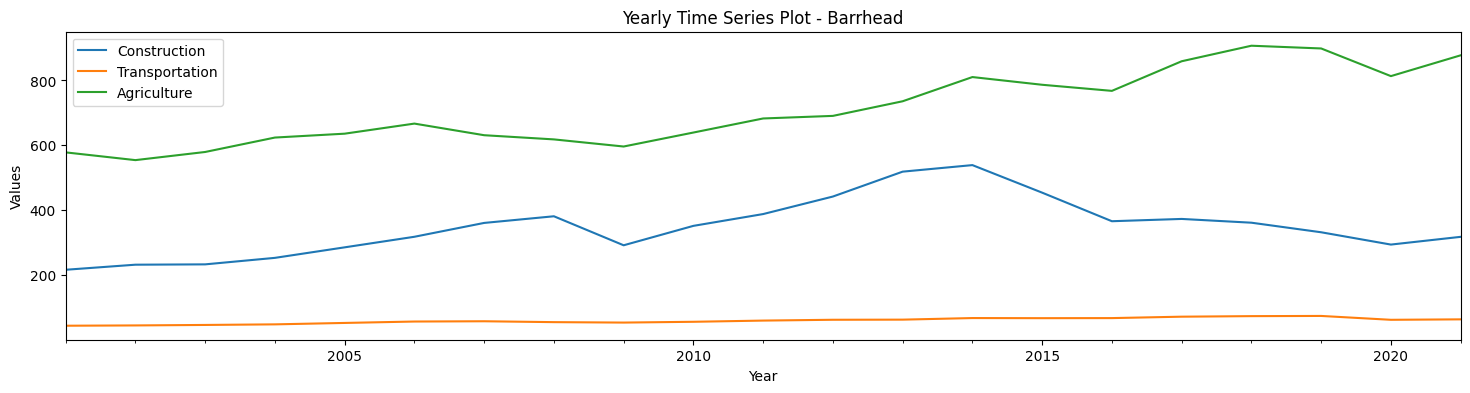

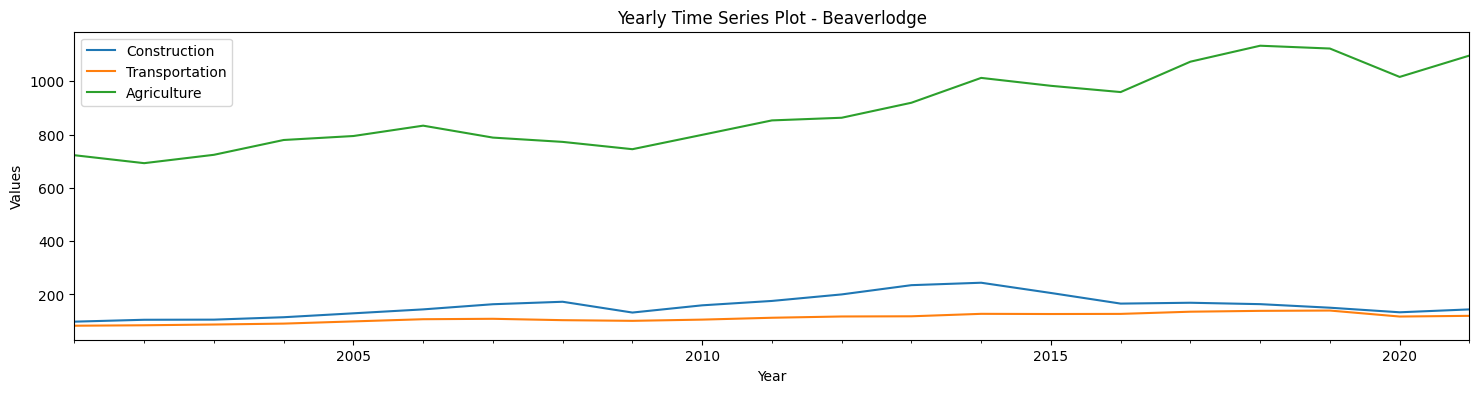

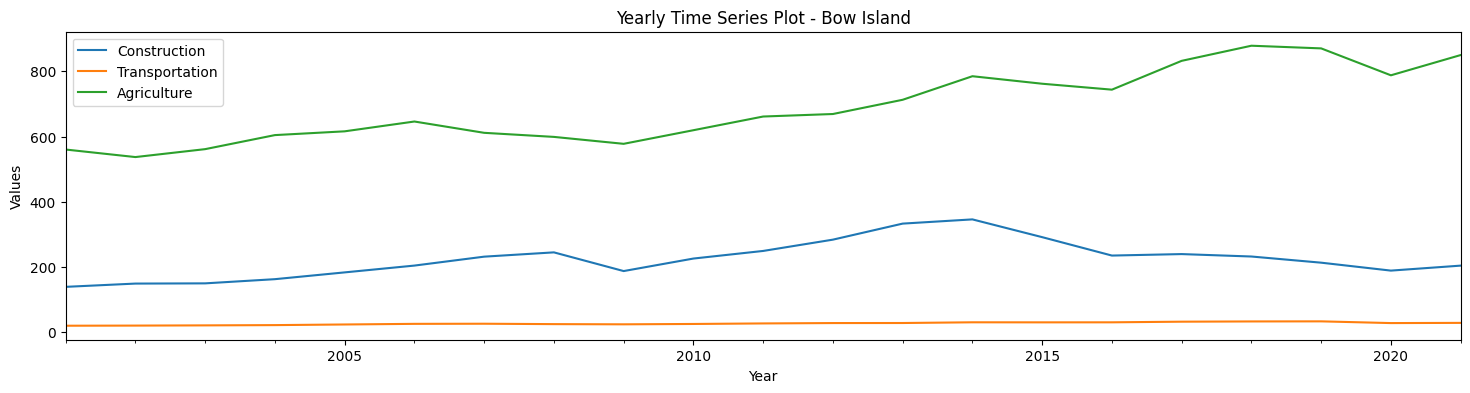

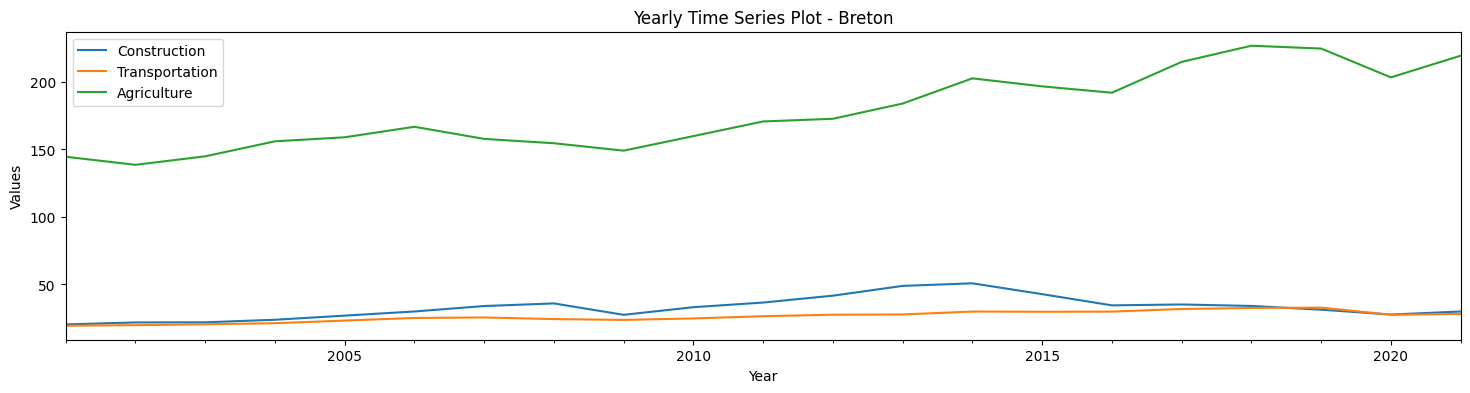

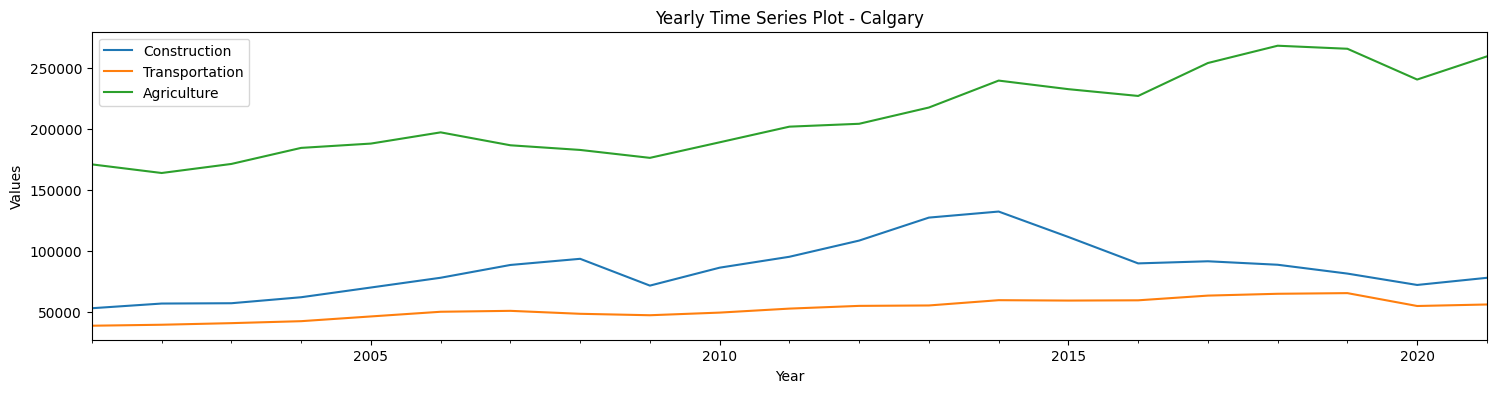

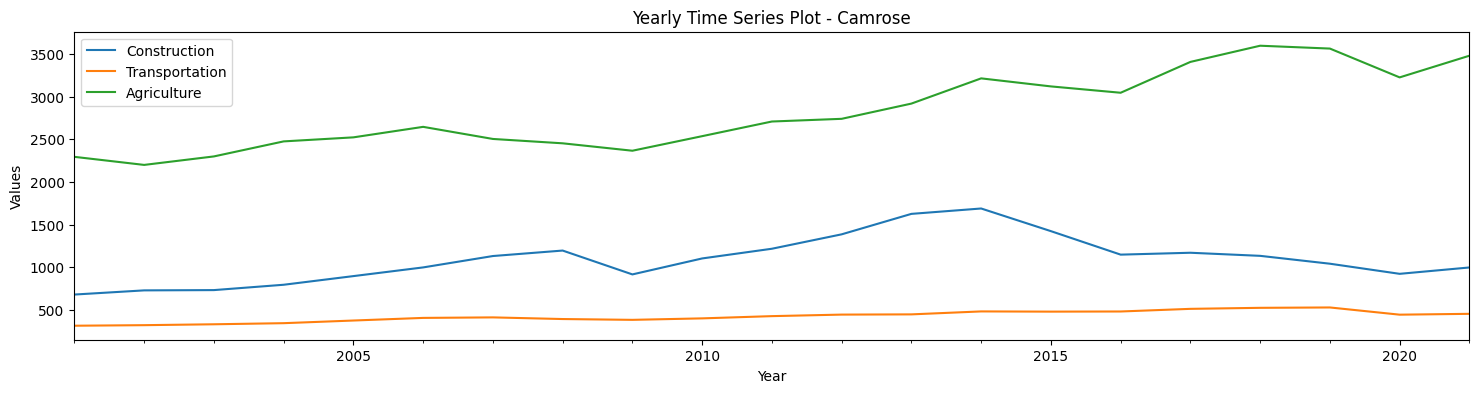

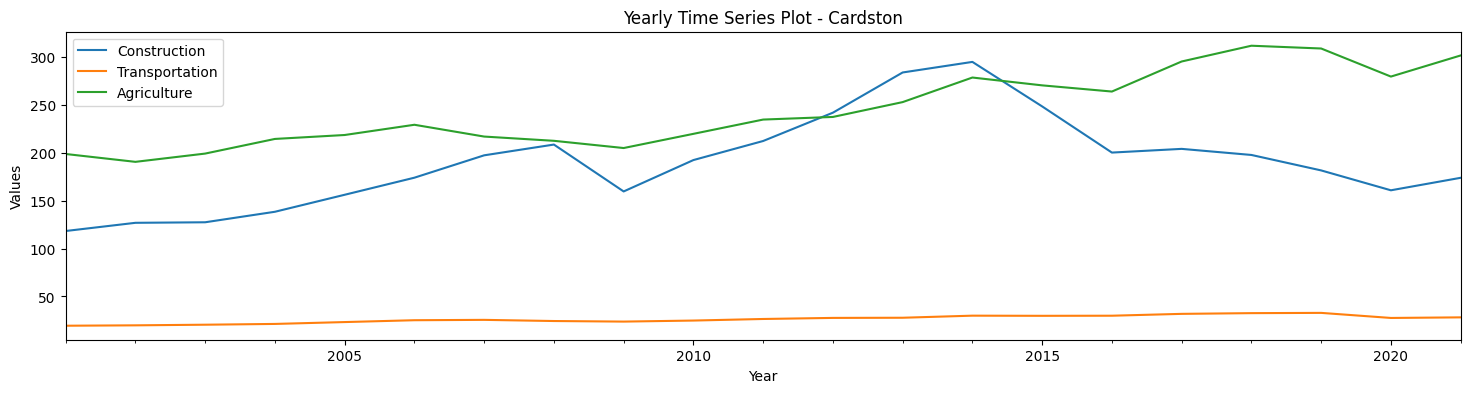

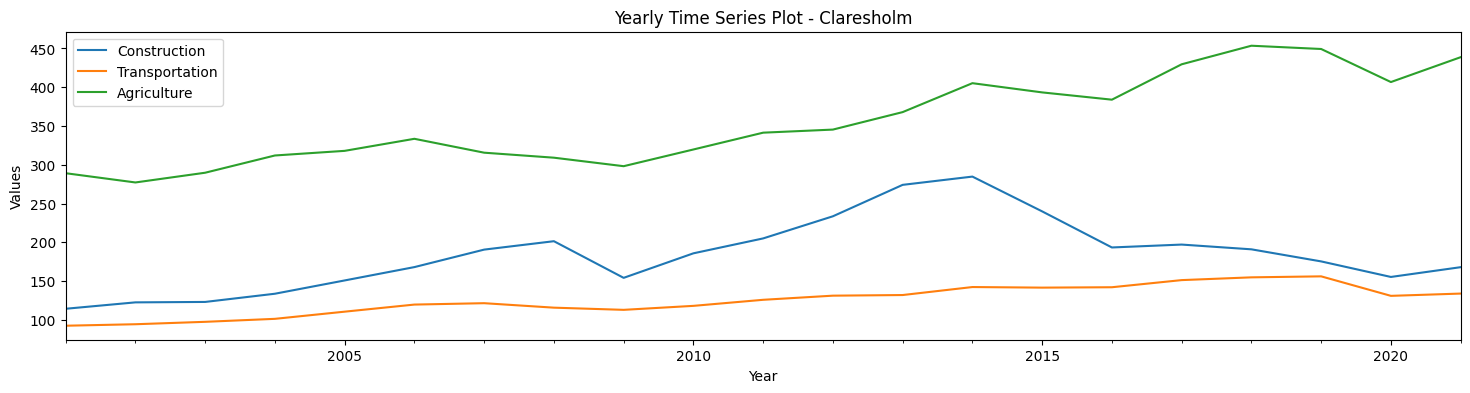

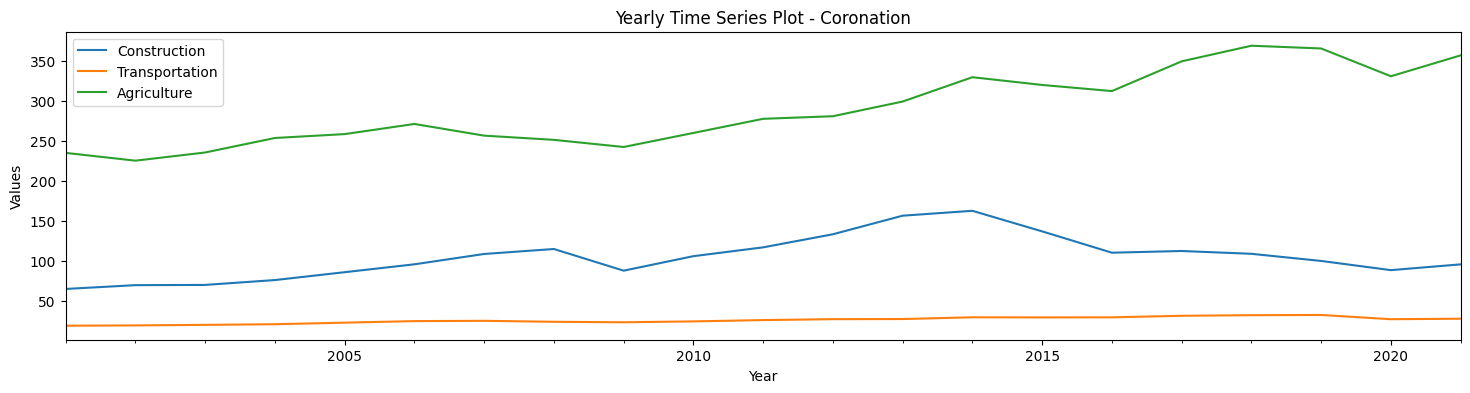

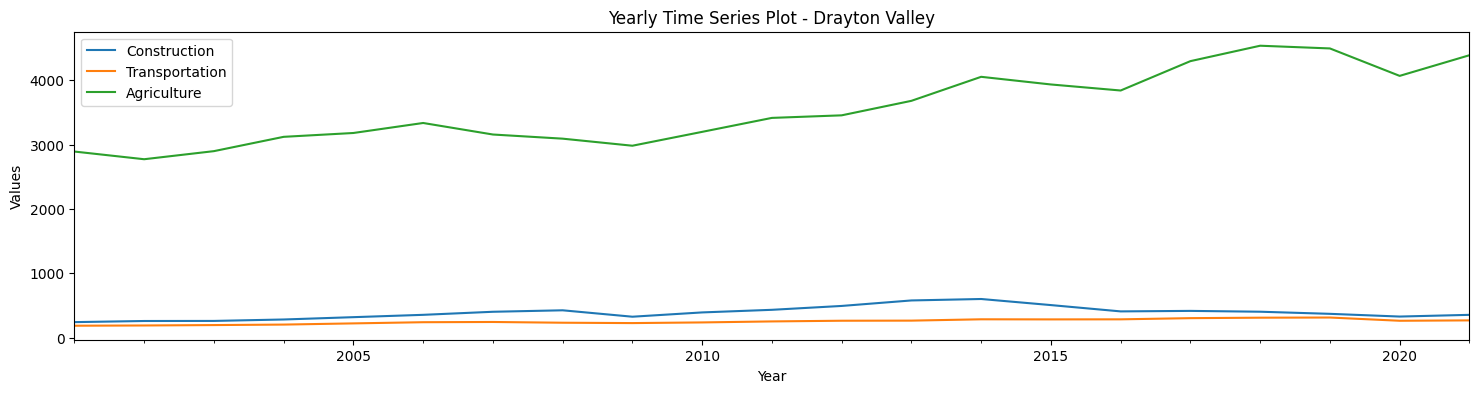

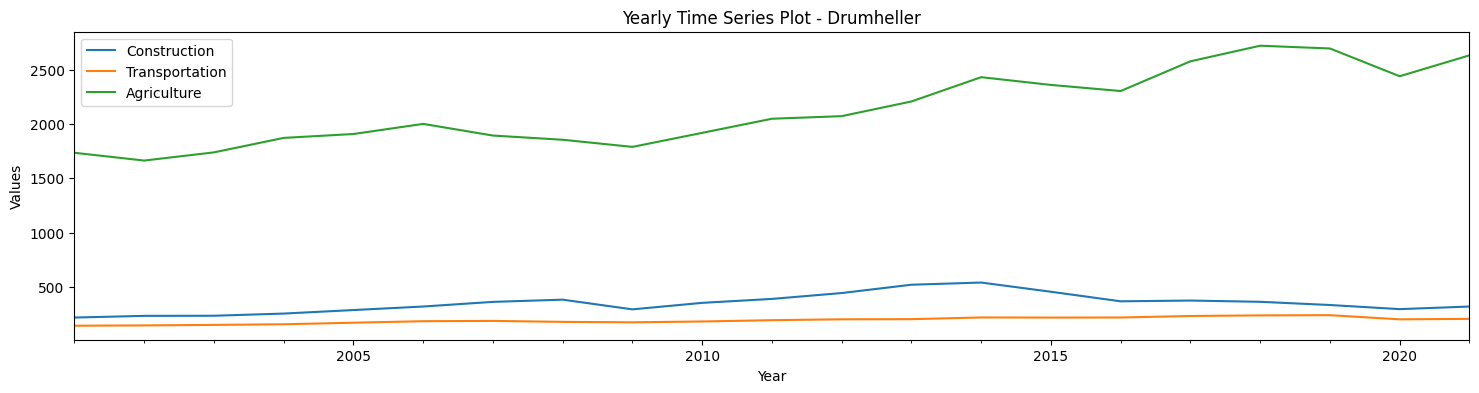

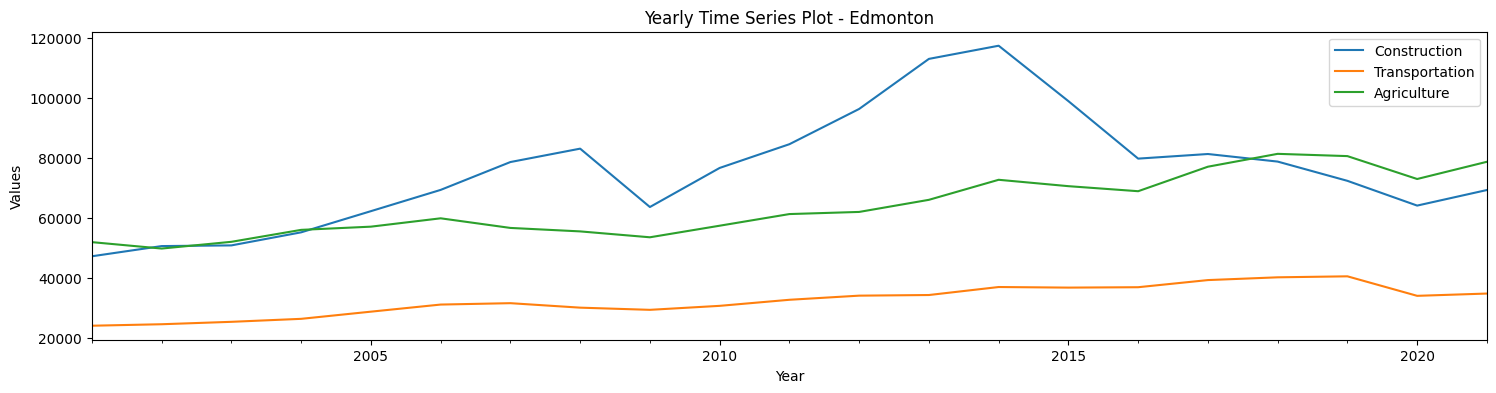

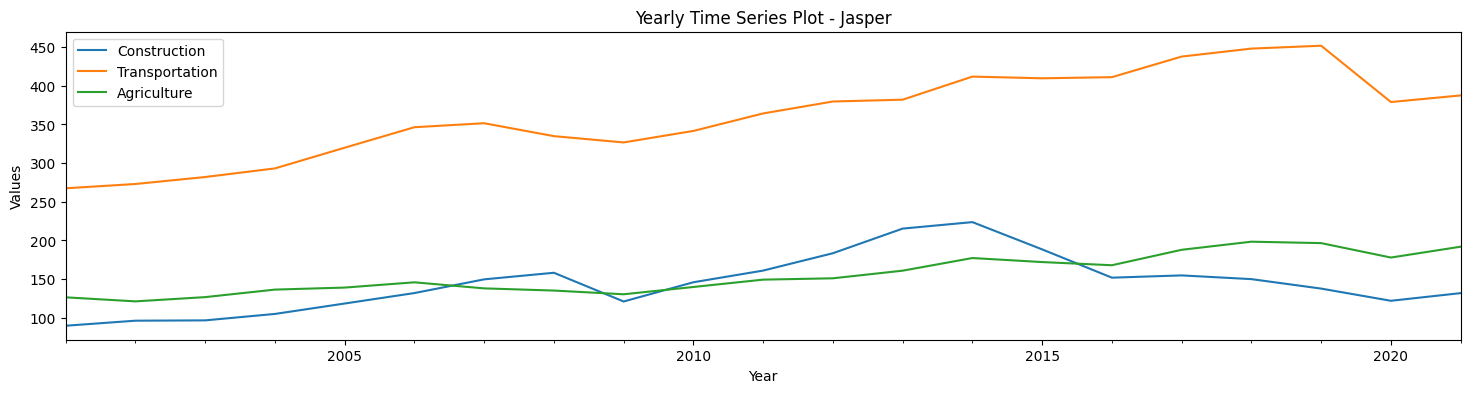

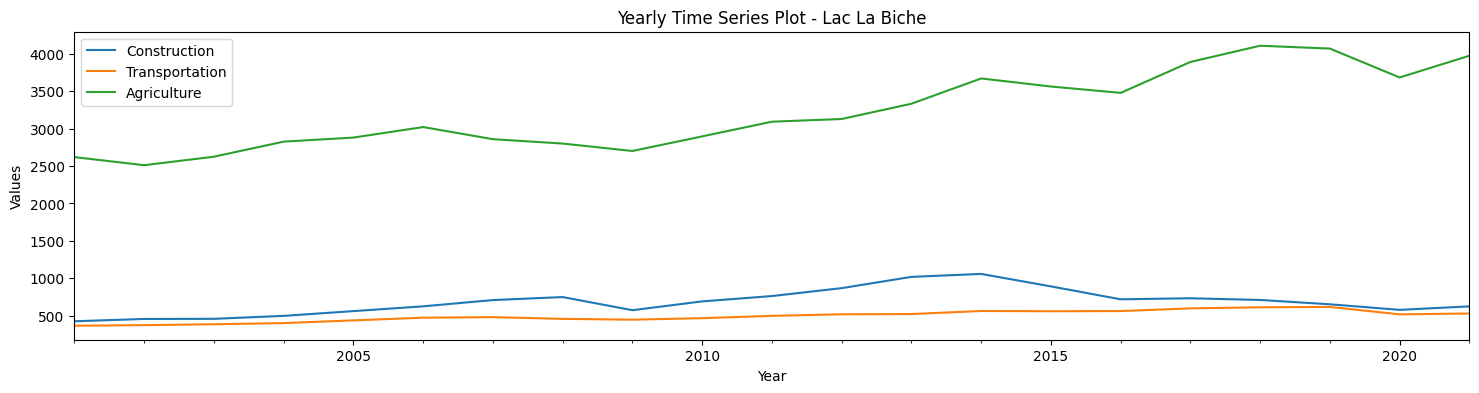

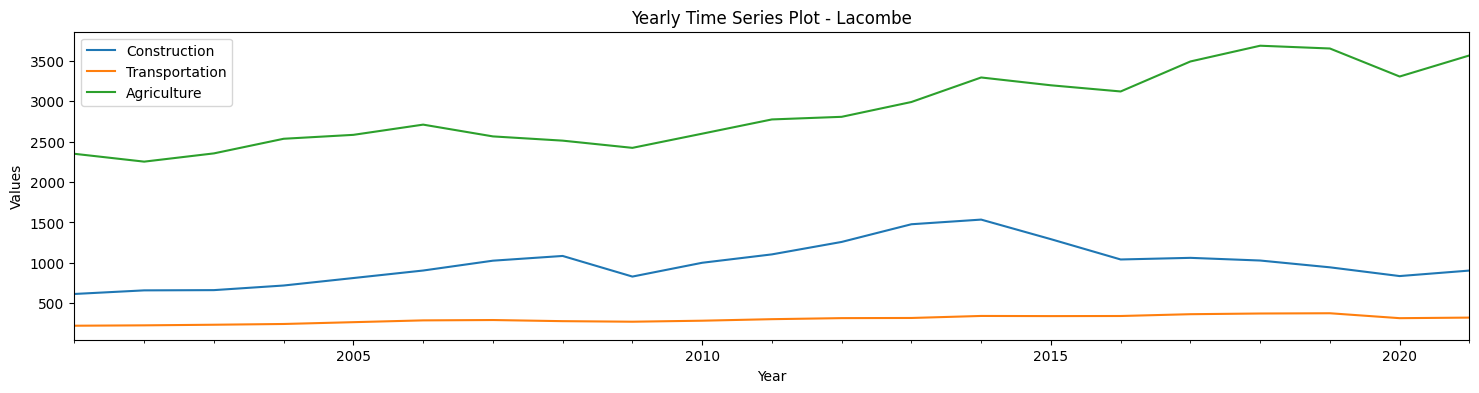

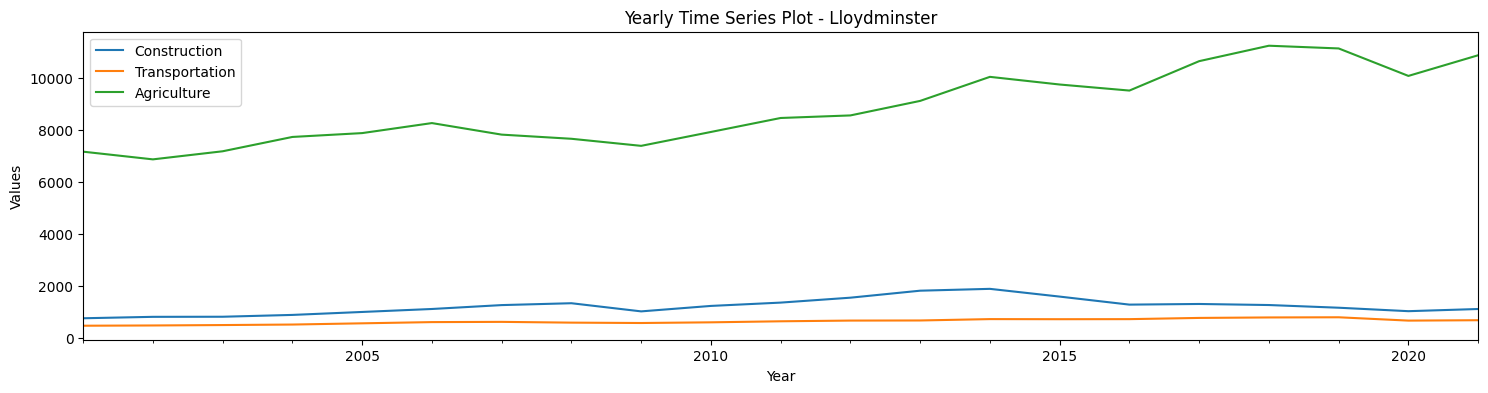

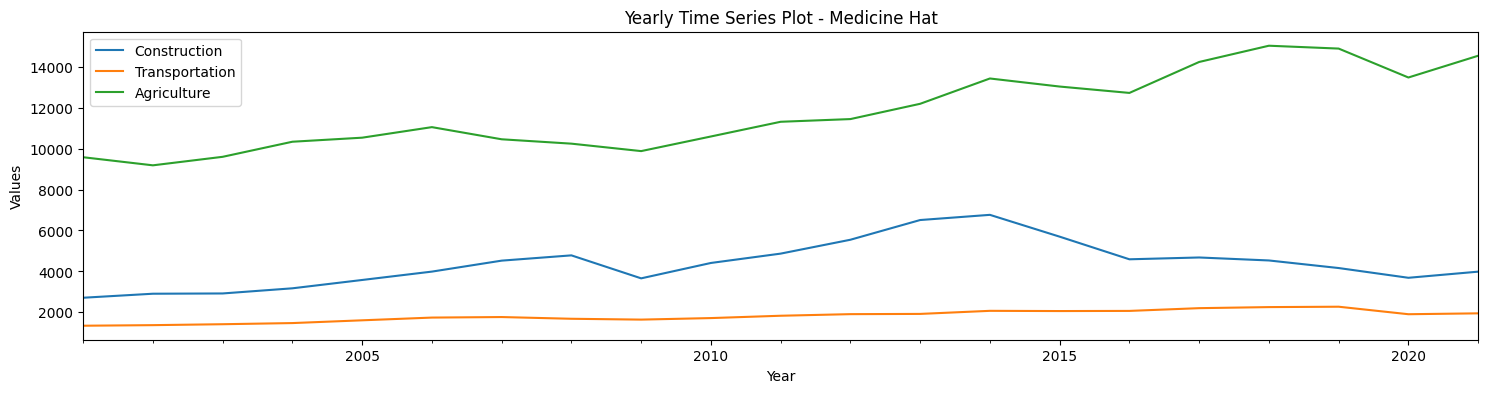

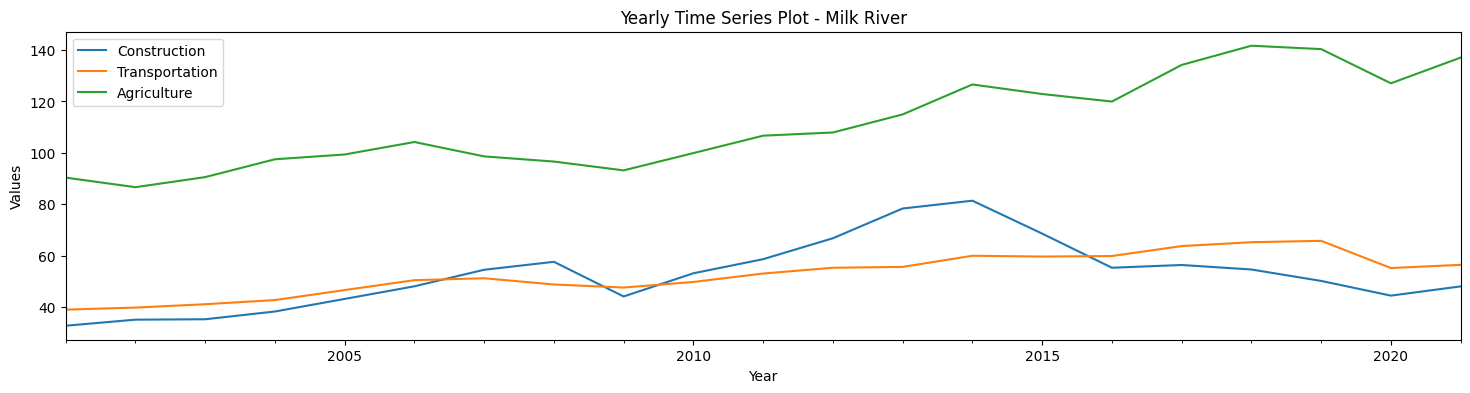

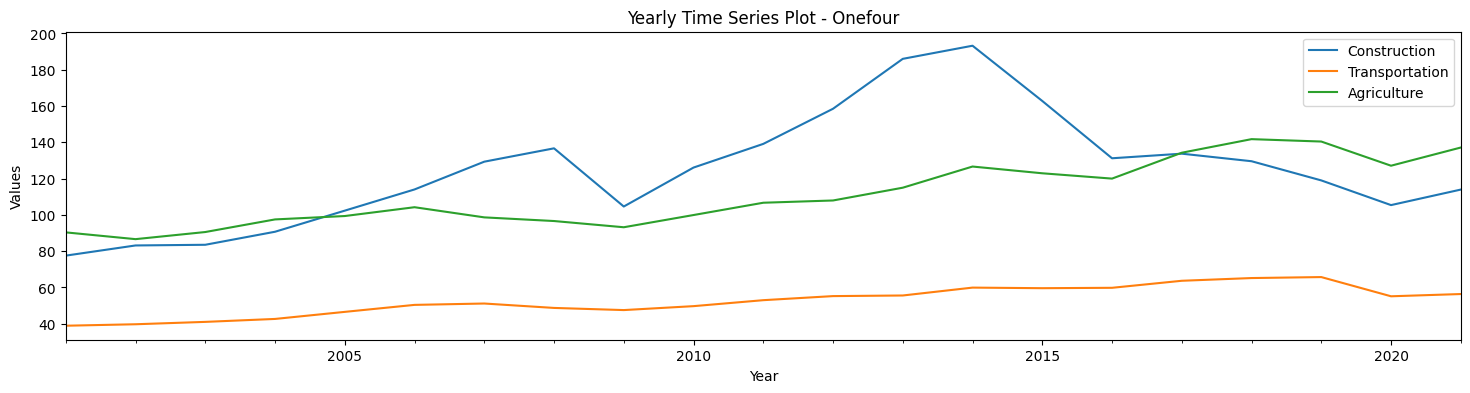

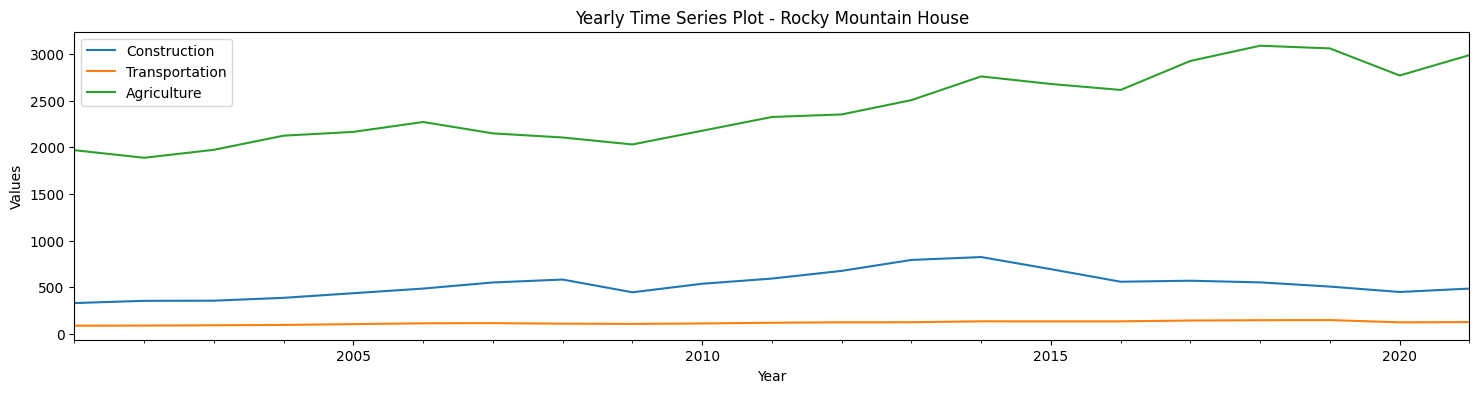

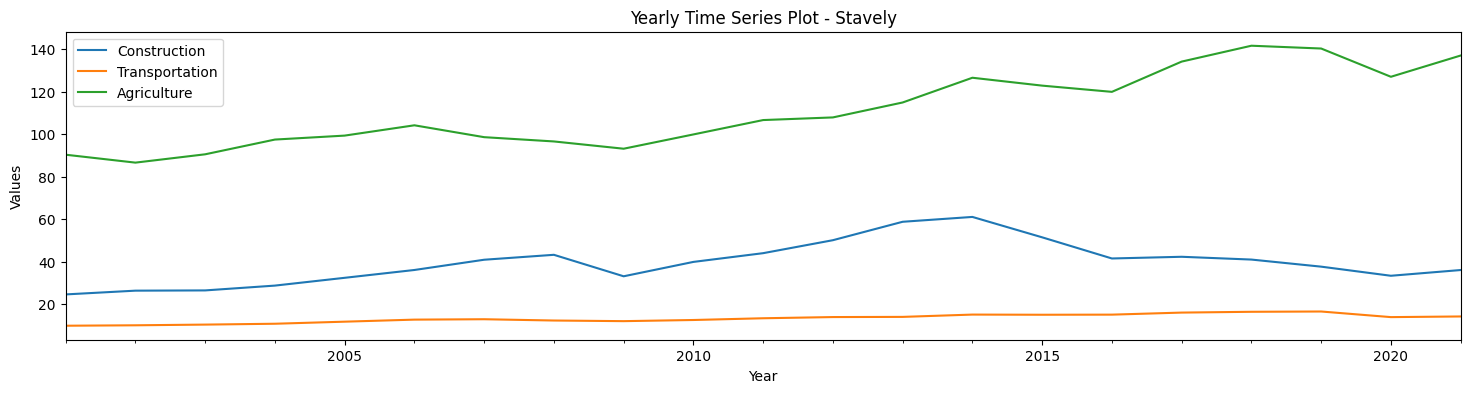

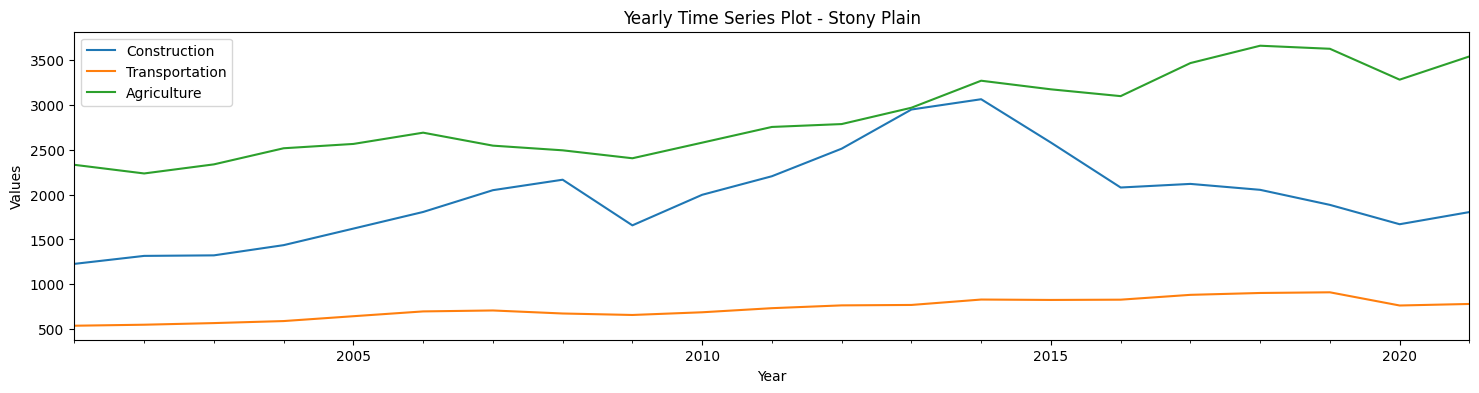

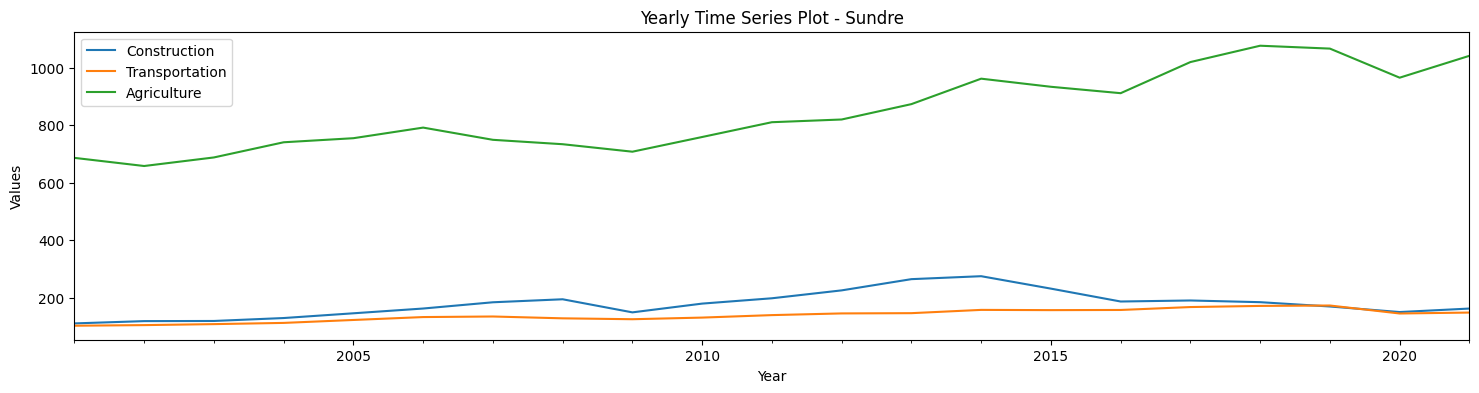

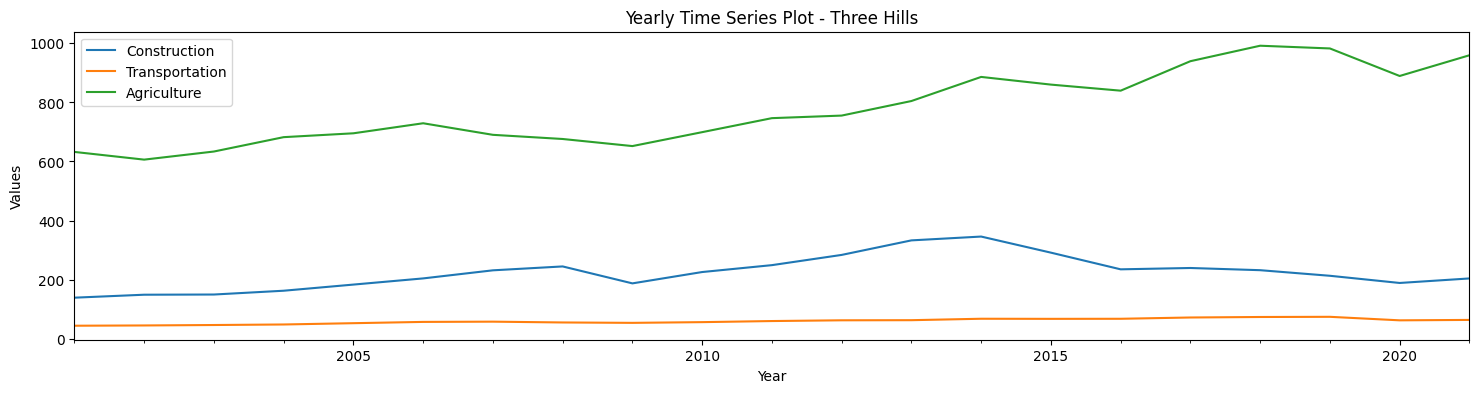

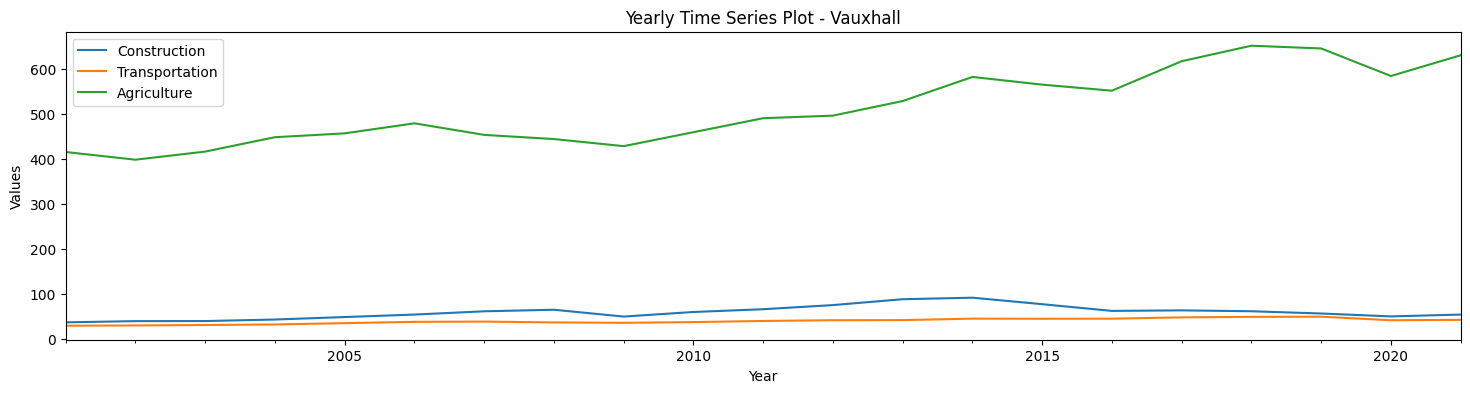

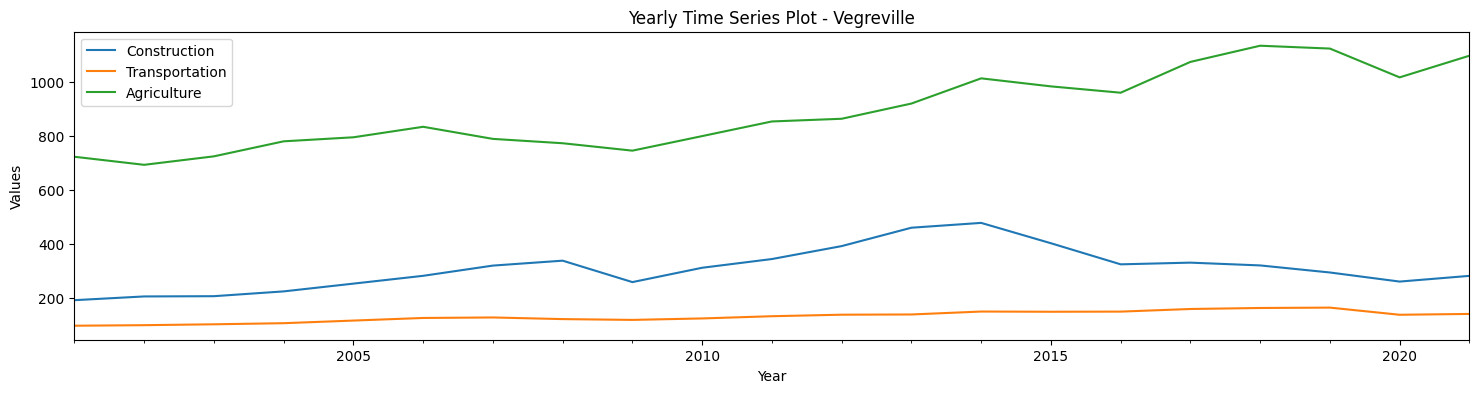

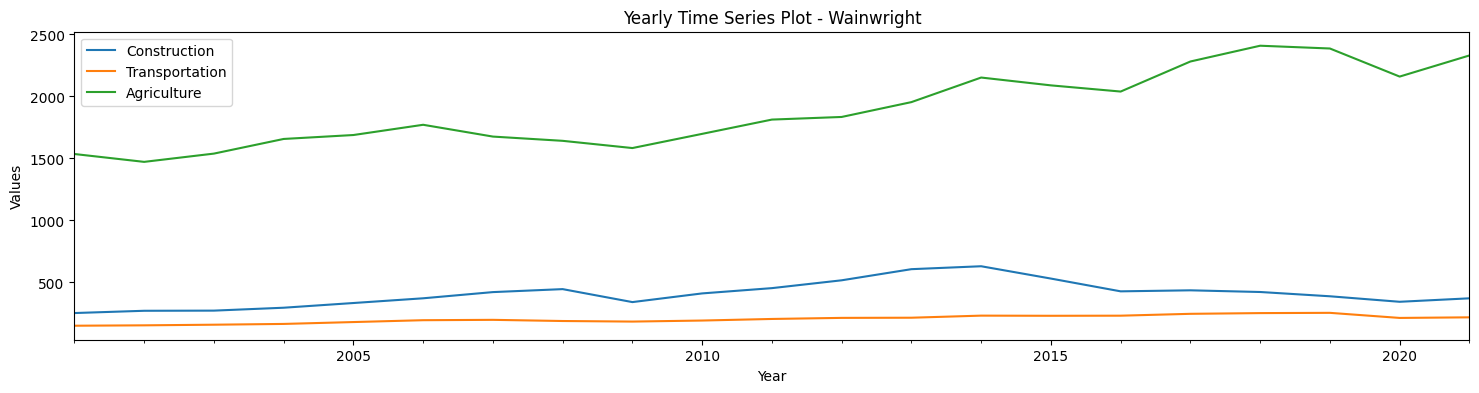

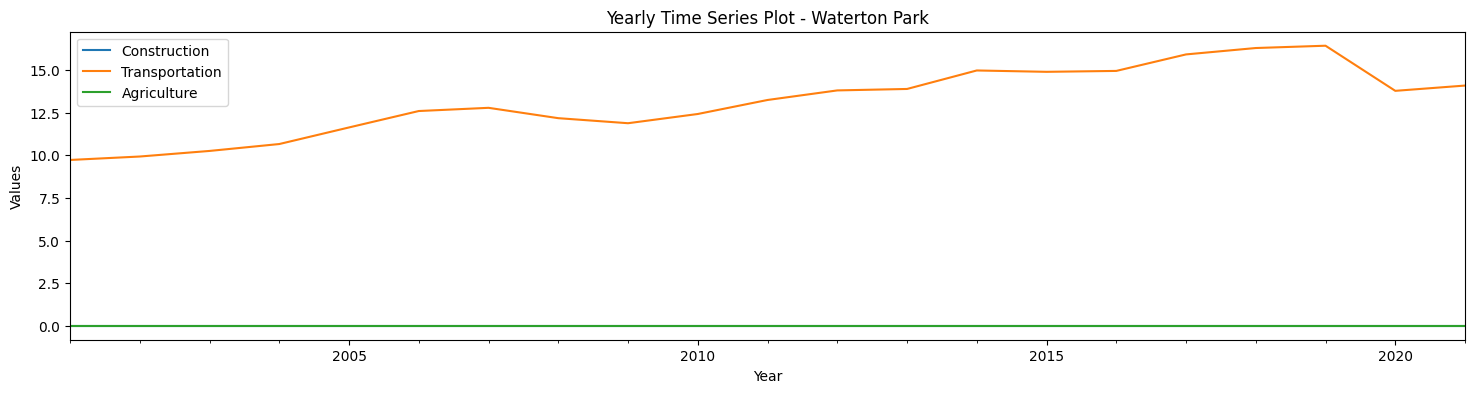

In [8]:
for station_name in unique_station_names:
    station_data = df[df['Station Name'] == station_name]
    yearly_data = station_data[productivity_columns].resample('Y').sum()
    yearly_data.plot(figsize=(18, 4), title=f'Yearly Time Series Plot - {station_name}')
    plt.xlabel('Year')
    plt.ylabel('Values')
    plt.show()

In [9]:
df.sample(5).T

Date,2016-08-01,2017-10-01,2012-01-01,2019-07-01,2016-04-01
provincename,Alberta,Alberta,Alberta,Alberta,Alberta
Construction,15.557175,28.885751,10.785955,15.162174,11.815581
Transportation,13.194527,13.089844,2.223667,2.708809,4.911516
Agriculture,77.883352,89.581278,23.786493,27.136875,9.762035
Population,2729,5708,940,3585,3713
Station Name,Sundre,Vegreville,Coronation,Cardston,Onefour
Max Temp (°C),23.0,11.4,-3.8,25.1,17.4
Total Snow (cm),2.618182,2.456061,0.1,0.607576,0.127273
Total Precip (mm),0.2,17.8,0.2,0.0,0.3
Min Temp (°C),9.0,0.7,-18.0,8.0,-0.4


# ARIMA 
## Construction Breton - Alberta

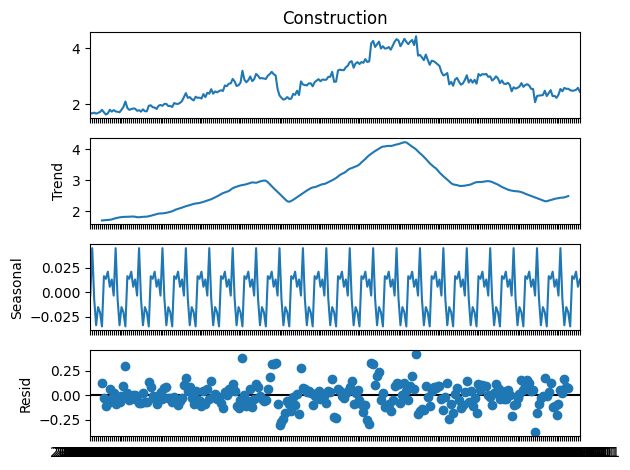

In [10]:
ConstructionBreton = pd.read_csv('Final.csv')
Construction_Breton = ConstructionBreton[ConstructionBreton['Station Name'] == 'Breton'][['Date', 'Construction']]
Construction_Breton.set_index('Date', inplace=True)
# Import seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
decomp = seasonal_decompose(Construction_Breton['Construction'],
                            period=12)

# Plot decomposition
decomp.plot()
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(Construction_Breton)
# Print test statistic
print(result)

(-1.7617018048350697, 0.39963451439398834, 1, 250, {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}, -244.1383955433593)


In [12]:
#Ho null hypostheis : It is non stationary
#H1 Alternate hypoyhesis : It is stationary

def adfuller_test(y):
    result=adfuller(y)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
adfuller_test(Construction_Breton['Construction'])    

ADF Test Statistic : -1.7617018048350697
p-value : 0.39963451439398834
#Lags Used : 1
Number of Observations Used : 250
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [13]:
Construction_Breton['Construction-diff'] = Construction_Breton['Construction'] - Construction_Breton['Construction'].shift(1)

In [14]:
adfuller_test(Construction_Breton['Construction-diff'].dropna())

ADF Test Statistic : -19.853418841614815
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 250
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Date'>

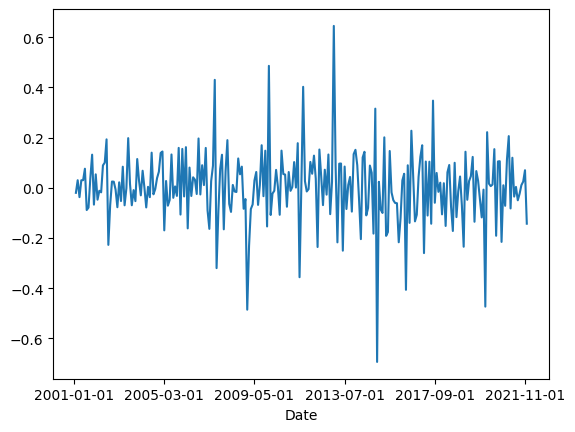

In [15]:
Construction_Breton['Construction-diff'].plot()

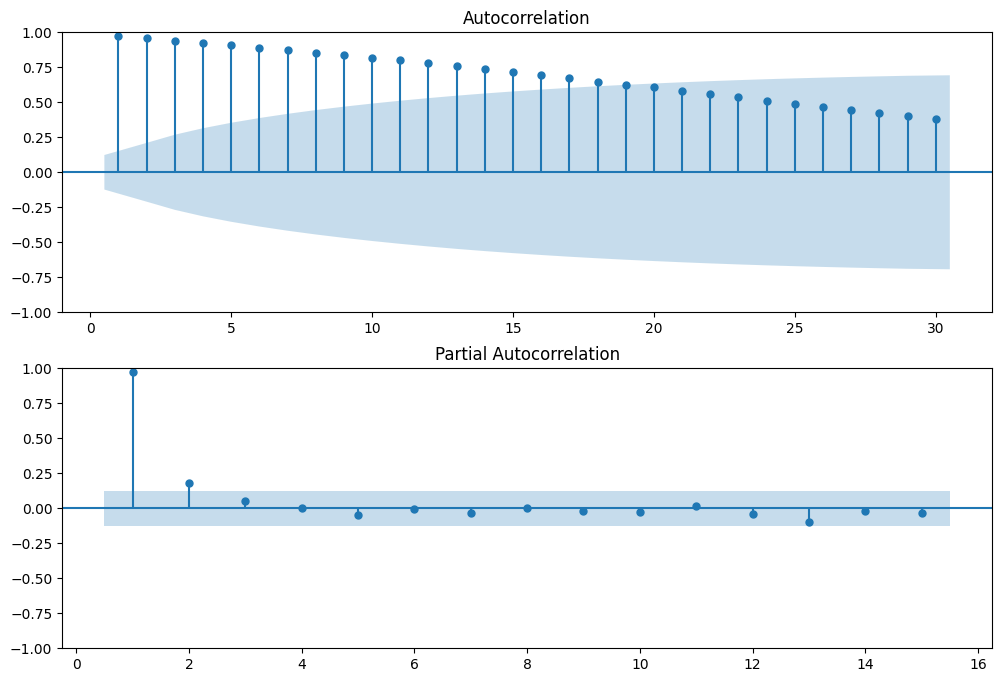

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(Construction_Breton['Construction'],zero=False,lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(Construction_Breton['Construction'],zero= False,lags=15,ax=ax2)


In [17]:
# Create empty list to store search results
order_aic_bic=[]
# Loop over p values from 0-2
for p in range(2):
# Loop over q values from 0-2
    for q in range(5):
        try:
            # Create and fit ARIMA(p,d,q) model
            model = sm.tsa.ARIMA(Construction_Breton['Construction'], order=(p,0,q), trend='c')
            results = model.fit()
            # Append order and results tuple
            order_aic_bic.append((p,q,results.aic, results.bic))
        except:
            print(p, q, None, None)

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

In [18]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

   p  q         AIC         BIC
6  1  1 -270.098068 -255.980352
7  1  2 -268.126788 -250.479643
8  1  3 -266.331239 -245.154665
9  1  4 -265.448577 -240.742574
5  1  0 -258.324935 -247.736648
4  0  4  -49.537392  -28.360818
3  0  3   15.070896   32.718042
2  0  2  101.021597  115.139313
1  0  1  268.384158  278.972445
0  0  0  527.397494  534.456352
   p  q         AIC         BIC
6  1  1 -270.098068 -255.980352
7  1  2 -268.126788 -250.479643
5  1  0 -258.324935 -247.736648
8  1  3 -266.331239 -245.154665
9  1  4 -265.448577 -240.742574
4  0  4  -49.537392  -28.360818
3  0  3   15.070896   32.718042
2  0  2  101.021597  115.139313
1  0  1  268.384158  278.972445
0  0  0  527.397494  534.456352


In [19]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
model = sm.tsa.ARIMA(Construction_Breton['Construction'], order=(1, 1, 1))
# Fit the model
results_ARIMAX = model.fit()

# Print model fit summary
print(results_ARIMAX.summary())

                               SARIMAX Results                                
Dep. Variable:           Construction   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 139.319
Date:                Mon, 08 Apr 2024   AIC                           -272.639
Time:                        00:48:36   BIC                           -262.062
Sample:                    01-01-2001   HQIC                          -268.382
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0470      0.262      0.179      0.858      -0.467       0.561
ma.L1         -0.2946      0.255     -1.153      0.249      -0.795       0.206
sigma2         0.0193      0.001     19.410      0.0

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [20]:
from datetime import datetime, timedelta
import pandas as pd

# Convert index to DateTimeIndex
Construction_Breton.index = pd.to_datetime(Construction_Breton.index)

train_dataset_end = datetime(2021, 6, 1)
test_dataset_end = datetime(2021, 12, 1)

train_data = Construction_Breton[Construction_Breton.index <= train_dataset_end]
test_data = Construction_Breton[(Construction_Breton.index > train_dataset_end) & (Construction_Breton.index <= test_dataset_end)]


In [21]:
model = sm.tsa.ARIMA(train_data['Construction'], order=(1, 1, 1))
results = model.fit()

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


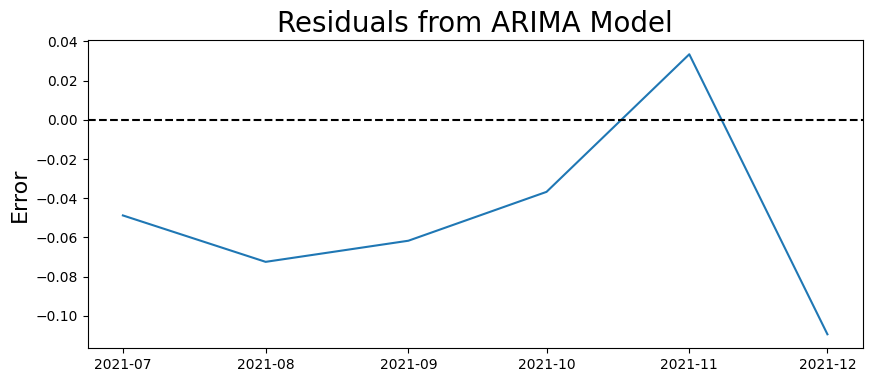

In [22]:
forecast_periods = len(test_data['Construction'])  # Number of periods to forecast
predictions = results.forecast(steps=forecast_periods)
predictions = pd.Series(predictions, index=test_data.index)
predictions
residuals = test_data['Construction'] - predictions
residuals
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.show()

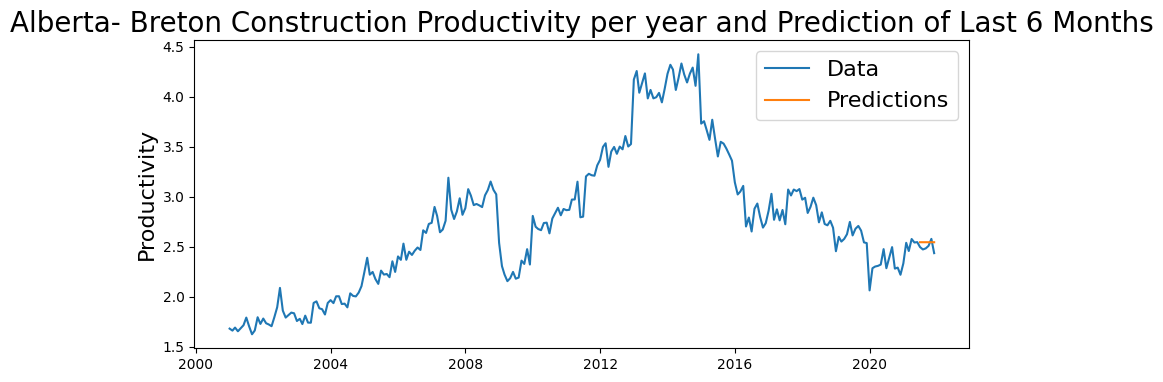

In [23]:
start_date = datetime(2021,6,1)
end_date = datetime(2021,12,1)

plt.figure(figsize=(10,4))

plt.plot(Construction_Breton['Construction'])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Alberta- Breton Construction Productivity per year and Prediction of Last 6 Months', fontsize=20)
plt.ylabel('Productivity', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [24]:
rmse = np.sqrt(np.mean(residuals**2))
print('Root Mean Squared Error:', rmse)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(residuals))
print('Mean Absolute Error:', mae)

# Calculate Mean Squared Error (MSE)
mse = np.mean(residuals**2)
print('Mean Squared Error:', mse)

Root Mean Squared Error: 0.0656494032458711
Mean Absolute Error: 0.060402752204392764
Mean Squared Error: 0.00430984414653899


# SARIMA 
## Construction Breton - Alberta

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

   p  q         AIC         BIC
6  1  1 -270.098068 -255.980352
7  1  2 -268.126788 -250.479643
8  1  3 -266.331239 -245.154665
9  1  4 -265.448577 -240.742574
5  1  0 -258.324935 -247.736648
4  0  4  -49.537392  -28.360818
3  0  3   15.070896   32.718042
2  0  2  101.021597  115.139313
1  0  1  268.384158  278.972445
0  0  0  527.397494  534.456352
   p  q         AIC         BIC
6  1  1 -270.098068 -255.980352
7  1  2 -268.126788 -250.479643
5  1  0 -258.324935 -247.736648
8  1  3 -266.331239 -245.154665
9  1  4 -265.448577 -240.742574
4  0  4  -49.537392  -28.360818
3  0  3   15.070896   32.718042
2  0  2  101.021597  115.139313
1  0  1  268.384158  278.972445
0  0  0  527.397494  534.456352


In [26]:
model_SARIMA=SARIMAX(Construction_Breton['Construction'],order=(1,1,1),seasonal_order=(1,0,1,12))
model_SARIMA_fit=model_SARIMA.fit()
model_SARIMA_fit.summary()

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Construction   No. Observations:                  252
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 140.845
Date:                            Mon, 08 Apr 2024   AIC                           -271.691
Time:                                    00:48:49   BIC                           -254.063
Sample:                                01-01-2001   HQIC                          -264.597
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0437      0.259      0.169      0.866      -0.464       0.551
ma.L1         -0.2982      0.252     -1.185      0.236      -0.791       0.195
ar.S.L12      -0.1496      0.427     -0.350      0.726      -0.987       0.688
ma.S.L12       0.2584      0.417      0.619      0.536      -0.560       1.076
sigma2         0.0190      0.001     17.127      0.000       0.017       0.021
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               217.53
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Predictions for last 6 months


In [27]:
from datetime import datetime,timedelta
train_dataset_end=datetime(2021,6,1)
test_dataset_end=datetime(2021,12,1)


train_data=Construction_Breton[:train_dataset_end]
test_data=Construction_Breton[train_dataset_end+timedelta(days=1):test_dataset_end]


In [28]:
#Fit SARIMA model
my_order = (1,1,1)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data['Construction'].dropna(), order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit()
print(model_fit.summary())

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                       Construction   No. Observations:                  246
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 135.130
Date:                            Mon, 08 Apr 2024   AIC                           -260.260
Time:                                    00:48:52   BIC                           -242.754
Sample:                                01-01-2001   HQIC                          -253.210
                                     - 06-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0400      0.265      0.151      0.880      -0.480       0.560
ma.L1         -0.2934      0.258   

Text(0, 0.5, 'Error')

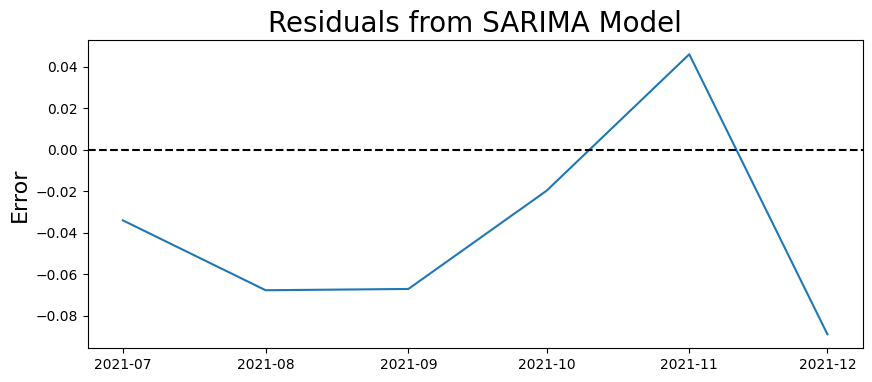

In [29]:
predictions = model_fit.forecast(steps=len(test_data['Construction']))
predictions = pd.Series(predictions, index=test_data.index)
predictions
residuals = test_data['Construction'] - predictions
residuals
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Sales')

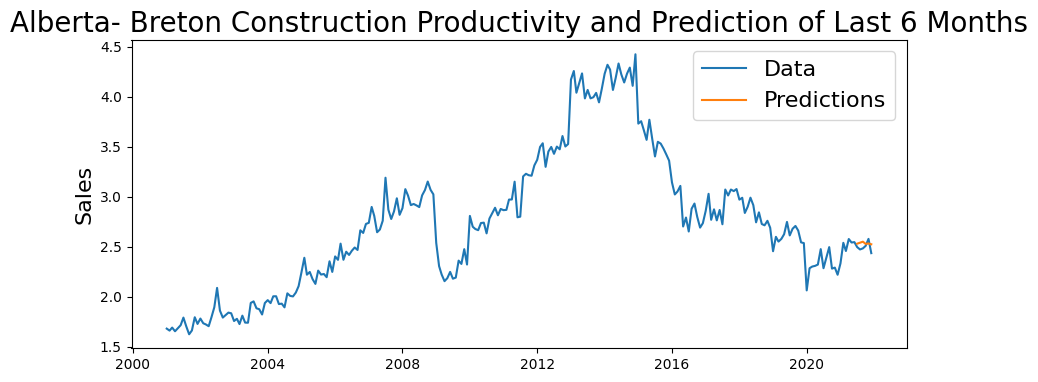

In [30]:
plt.figure(figsize=(10,4))

plt.plot(Construction_Breton['Construction'])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Alberta- Breton Construction Productivity and Prediction of Last 6 Months', fontsize=20)
plt.ylabel('Sales', fontsize=16)


In [31]:
rmse = np.sqrt(np.mean(residuals**2))
print('Root Mean Squared Error:', rmse)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(residuals))
print('Mean Absolute Error:', mae)

# Calculate Mean Squared Error (MSE)
mse = np.mean(residuals**2)
print('Mean Squared Error:', mse)

Root Mean Squared Error: 0.05862421800217966
Mean Absolute Error: 0.053872923834982656
Mean Squared Error: 0.003436798936367086


# ARIMA 
## Transportation Stavely - Alberta

In [32]:
TransportationStavely = pd.read_csv('Final.csv')

In [33]:
Transportation_Stavely = TransportationStavely[TransportationStavely['Station Name'] == 'Stavely'][['Date', 'Transportation']]

In [34]:
Transportation_Stavely.set_index('Date', inplace=True)


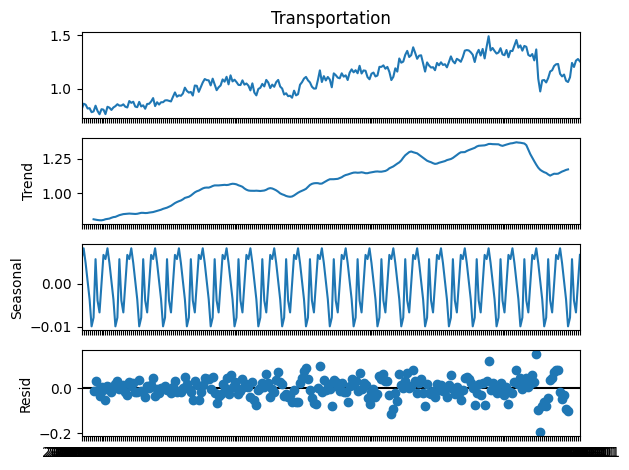

In [35]:
# Import seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
decomp = seasonal_decompose(Transportation_Stavely['Transportation'],
                            period=12)

# Plot decomposition
decomp.plot()
plt.show()

In [36]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(Transportation_Stavely)
# Print test statistic
print(result)

(-1.6974563382802585, 0.4324235221760687, 2, 249, {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}, -752.6377524468558)


In [37]:
#Ho null hypostheis : It is non stationary
#H1 Alternate hypoyhesis : It is stationary

def adfuller_test(y):
    result=adfuller(y)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [38]:
adfuller_test(Transportation_Stavely['Transportation'])

ADF Test Statistic : -1.6974563382802585
p-value : 0.4324235221760687
#Lags Used : 2
Number of Observations Used : 249
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [39]:
Transportation_Stavely['Transportation-d'] = Transportation_Stavely['Transportation'] - Transportation_Stavely['Transportation'].shift(1)

In [40]:
adfuller_test(Transportation_Stavely['Transportation-d'].dropna())

ADF Test Statistic : -15.072503887375438
p-value : 8.683998352943773e-28
#Lags Used : 1
Number of Observations Used : 249
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Date'>

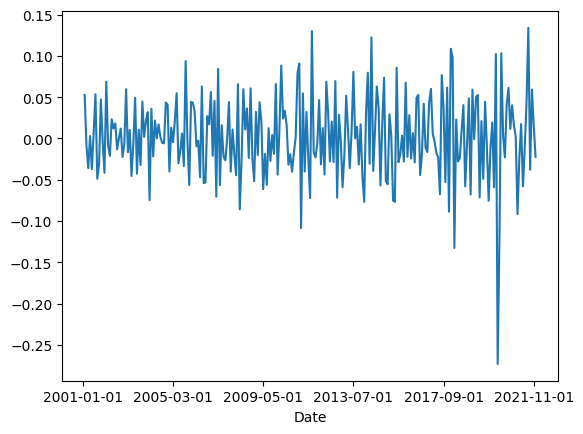

In [41]:
Transportation_Stavely['Transportation-d'].plot()

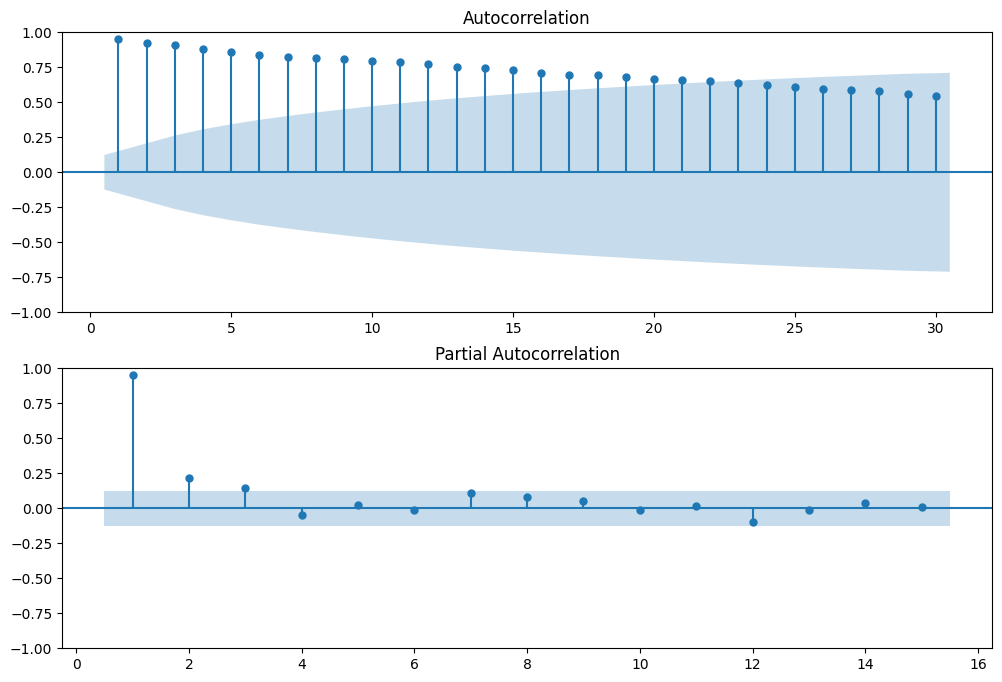

In [42]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(Transportation_Stavely['Transportation'],zero=False,lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(Transportation_Stavely['Transportation'],zero= False,lags=15,ax=ax2)


In [43]:
# Create empty list to store search results
order_aic_bic=[]
# Loop over p values from 0-2
for p in range(2):
# Loop over q values from 0-2
    for q in range(5):
        try:
            # Create and fit ARIMA(p,d,q) model
            model = sm.tsa.ARIMA(Transportation_Stavely['Transportation'], order=(p,0,q), trend='c')
            results = model.fit()
            # Append order and results tuple
            order_aic_bic.append((p,q,results.aic, results.bic))
        except:
            print(p, q, None, None)

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\bas

In [44]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

   p  q         AIC         BIC
6  1  1 -807.927863 -793.810147
9  1  4 -807.855942 -783.149938
7  1  2 -807.246555 -789.599409
8  1  3 -806.726958 -785.550383
5  1  0 -790.188625 -779.600337
4  0  4 -642.789200 -621.612625
3  0  3 -604.079581 -586.432435
2  0  2 -520.141830 -506.024114
1  0  1 -416.957643 -406.369356
0  0  0 -166.330100 -159.271242
   p  q         AIC         BIC
6  1  1 -807.927863 -793.810147
7  1  2 -807.246555 -789.599409
8  1  3 -806.726958 -785.550383
9  1  4 -807.855942 -783.149938
5  1  0 -790.188625 -779.600337
4  0  4 -642.789200 -621.612625
3  0  3 -604.079581 -586.432435
2  0  2 -520.141830 -506.024114
1  0  1 -416.957643 -406.369356
0  0  0 -166.330100 -159.271242


In [45]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
model = sm.tsa.ARIMA(Transportation_Stavely['Transportation'], order=(1, 1, 4))
# Fit the model
results_ARIMAX = model.fit()

# Print model fit summary
print(results_ARIMAX.summary())

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         Transportation   No. Observations:                  252
Model:                 ARIMA(1, 1, 4)   Log Likelihood                 411.671
Date:                Mon, 08 Apr 2024   AIC                           -811.341
Time:                        00:49:16   BIC                           -790.189
Sample:                    01-01-2001   HQIC                          -802.829
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6377      0.235      2.717      0.007       0.178       1.098
ma.L1         -0.9539      0.231     -4.136      0.000      -1.406      -0.502
ma.L2          0.0770      0.096      0.801      0.4

# Use testing data as of last six months

In [46]:
from datetime import datetime, timedelta
import pandas as pd

# Convert index to DateTimeIndex
Transportation_Stavely.index = pd.to_datetime(Transportation_Stavely.index)

train_dataset_end = datetime(2021, 6, 1)
test_dataset_end = datetime(2021, 12, 1)

train_data = Transportation_Stavely[Transportation_Stavely.index <= train_dataset_end]
test_data = Transportation_Stavely[(Transportation_Stavely.index > train_dataset_end) & (Transportation_Stavely.index <= test_dataset_end)]


In [47]:
test_data

,Transportation,Transportation-d
Date,,
2021-07-01,1.106247,0.044356
2021-08-01,1.240079,0.133832
2021-09-01,1.202209,-0.037870
2021-10-01,1.261386,0.059177
2021-11-01,1.276510,0.015124
2021-12-01,1.254253,-0.022257


In [48]:
model = sm.tsa.ARIMA(train_data['Transportation'], order=(1, 1, 4))
results = model.fit()

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [49]:
forecast_periods = len(test_data['Transportation'])  # Number of periods to forecast
predictions = results.forecast(steps=forecast_periods)
predictions = pd.Series(predictions, index=test_data.index)
predictions



Date
2021-07-01    1.083274
2021-08-01    1.084804
2021-09-01    1.088429
2021-10-01    1.095283
2021-11-01    1.099546
2021-12-01    1.102199
Name: predicted_mean, dtype: float64

In [50]:
residuals = test_data['Transportation'] - predictions
residuals

Date
2021-07-01    0.022973
2021-08-01    0.155275
2021-09-01    0.113780
2021-10-01    0.166103
2021-11-01    0.176963
2021-12-01    0.152054
dtype: float64

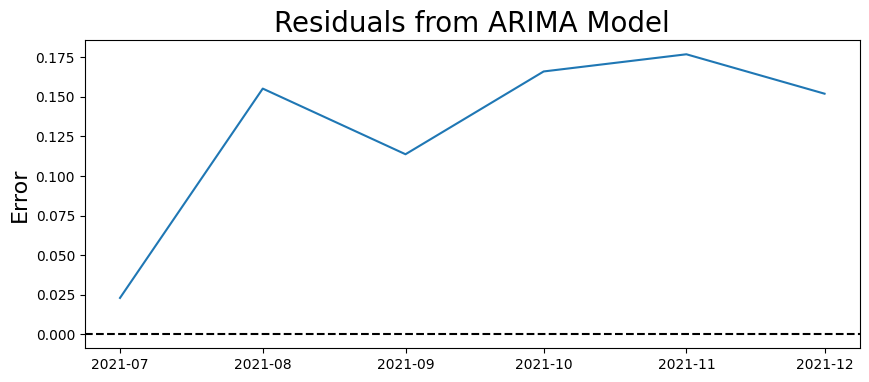

In [51]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.show()

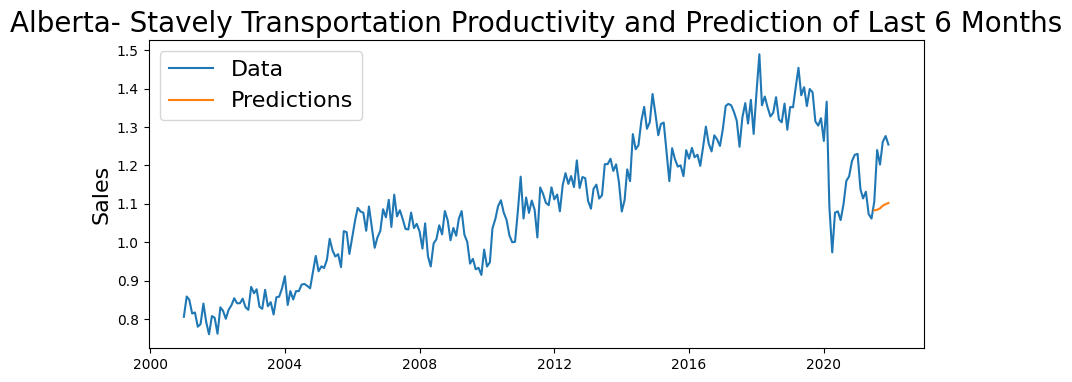

In [52]:
start_date = datetime(2021,6,1)
end_date = datetime(2021,12,1)

plt.figure(figsize=(10,4))

plt.plot(Transportation_Stavely['Transportation'])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Alberta- Stavely Transportation Productivity and Prediction of Last 6 Months', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [53]:
rmse = np.sqrt(np.mean(residuals**2))
print('Root Mean Squared Error:', rmse)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(residuals))
print('Mean Absolute Error:', mae)

# Calculate Mean Squared Error (MSE)
mse = np.mean(residuals**2)
print('Mean Squared Error:', mse)

Root Mean Squared Error: 0.14119168289723416
Mean Absolute Error: 0.1311913028463787
Mean Squared Error: 0.01993509131935313


# SARIMA

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

   p  q         AIC         BIC
6  1  1 -807.927863 -793.810147
9  1  4 -807.855942 -783.149938
7  1  2 -807.246555 -789.599409
8  1  3 -806.726958 -785.550383
5  1  0 -790.188625 -779.600337
4  0  4 -642.789200 -621.612625
3  0  3 -604.079581 -586.432435
2  0  2 -520.141830 -506.024114
1  0  1 -416.957643 -406.369356
0  0  0 -166.330100 -159.271242
   p  q         AIC         BIC
6  1  1 -807.927863 -793.810147
7  1  2 -807.246555 -789.599409
8  1  3 -806.726958 -785.550383
9  1  4 -807.855942 -783.149938
5  1  0 -790.188625 -779.600337
4  0  4 -642.789200 -621.612625
3  0  3 -604.079581 -586.432435
2  0  2 -520.141830 -506.024114
1  0  1 -416.957643 -406.369356
0  0  0 -166.330100 -159.271242


In [55]:
model_SARIMA=SARIMAX(Transportation_Stavely['Transportation'],order=(0,1,0),seasonal_order=(1,0,4,12))
model_SARIMA_fit=model_SARIMA.fit()
model_SARIMA_fit.summary()

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:                                Transportation   No. Observations:                  252
Model:             SARIMAX(0, 1, 0)x(1, 0, [1, 2, 3, 4], 12)   Log Likelihood                 398.856
Date:                                       Mon, 08 Apr 2024   AIC                           -785.712
Time:                                               00:49:29   BIC                           -764.560
Sample:                                           01-01-2001   HQIC                          -777.200
                                                - 12-01-2021                                         
Covariance Type:                                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.7874      0.207      3.811      0.000       0.382       1.192
ma.S.L12      -0.8611      0.234     -3.684      0.000      -1.319      -0.403
ma.S.L24       0.1128      0.092      1.225      0.220      -0.068       0.293
ma.S.L36      -0.0772      0.103     -0.751      0.452      -0.279       0.124
ma.S.L48      -0.0926      0.090     -1.029      0.303      -0.269       0.084
sigma2         0.0024      0.000     10.141      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                  14.92   Jarque-Bera (JB):                38.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.64   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Predictions for last 6 months


In [56]:
from datetime import datetime,timedelta
train_dataset_end=datetime(2021,6,1)
test_dataset_end=datetime(2021,12,1)


train_data=Transportation_Stavely[:train_dataset_end]
test_data=Transportation_Stavely[train_dataset_end+timedelta(days=1):test_dataset_end]


In [57]:
#Fit SARIMA model
my_order = (0,1,0)
my_seasonal_order = (1, 0, 4, 12)
# define model
model = SARIMAX(train_data['Transportation'].dropna(), order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit()
print(model_fit.summary())

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                           SARIMAX Results                                           
Dep. Variable:                                Transportation   No. Observations:                  246
Model:             SARIMAX(0, 1, 0)x(1, 0, [1, 2, 3, 4], 12)   Log Likelihood                 392.783
Date:                                       Mon, 08 Apr 2024   AIC                           -773.565
Time:                                               00:49:37   BIC                           -752.558
Sample:                                           01-01-2001   HQIC                          -765.106
                                                - 06-01-2021                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.7764     

Text(0, 0.5, 'Error')

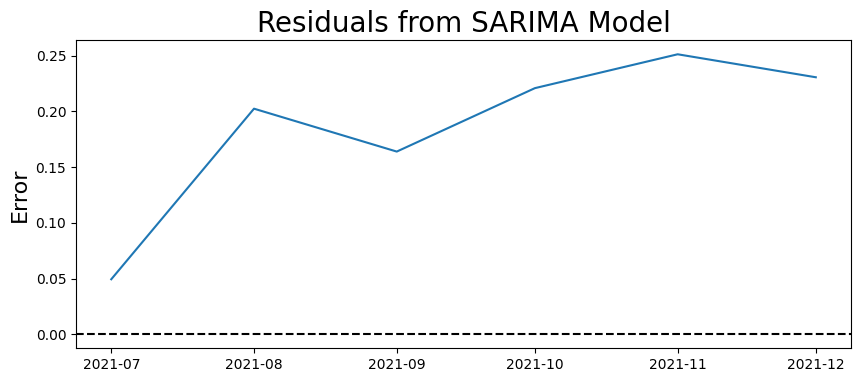

In [58]:
predictions = model_fit.forecast(steps=len(test_data['Transportation']))
predictions = pd.Series(predictions, index=test_data.index)
predictions
residuals = test_data['Transportation'] - predictions
residuals
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Sales')

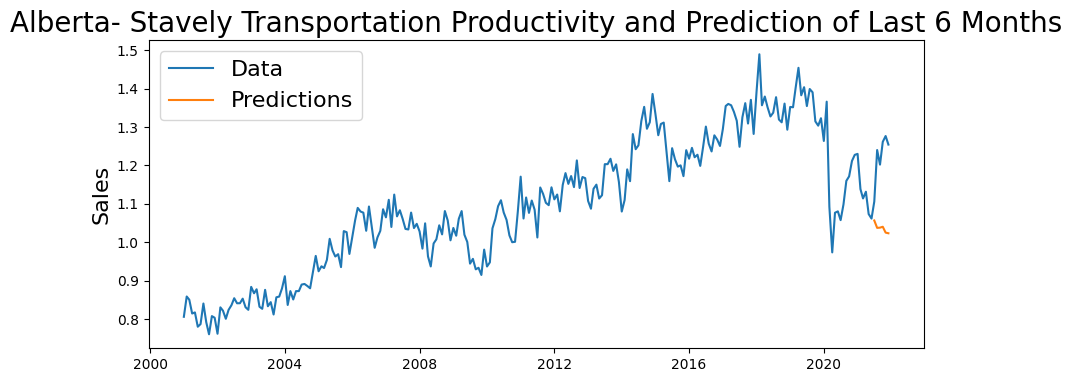

In [59]:
plt.figure(figsize=(10,4))

plt.plot(Transportation_Stavely['Transportation'])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Alberta- Stavely Transportation Productivity and Prediction of Last 6 Months', fontsize=20)
plt.ylabel('Sales', fontsize=16)


In [60]:
rmse = np.sqrt(np.mean(residuals**2))
print('Root Mean Squared Error:', rmse)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(residuals))
print('Mean Absolute Error:', mae)

# Calculate Mean Squared Error (MSE)
mse = np.mean(residuals**2)
print('Mean Squared Error:', mse)

Root Mean Squared Error: 0.19796034644080462
Mean Absolute Error: 0.18630977772659052
Mean Squared Error: 0.03918829876296339


# ARIMA 
## Agriculture Milk River - Alberta

In [61]:
Agriculture = pd.read_csv('Final.csv')

In [62]:
Agriculture_MilkRiver = Agriculture[Agriculture['Station Name'] == 'Milk River'][['Date', 'Agriculture']]

In [63]:
Agriculture_MilkRiver.set_index('Date', inplace=True)


In [64]:
Agriculture_MilkRiver

,Agriculture
Date,
2001-01-01,7.069979
2001-02-01,7.369142
2001-03-01,7.321915
2001-04-01,7.673358
2001-05-01,7.564151
...,...
2021-08-01,11.361954
2021-09-01,11.798399
2021-10-01,12.194492


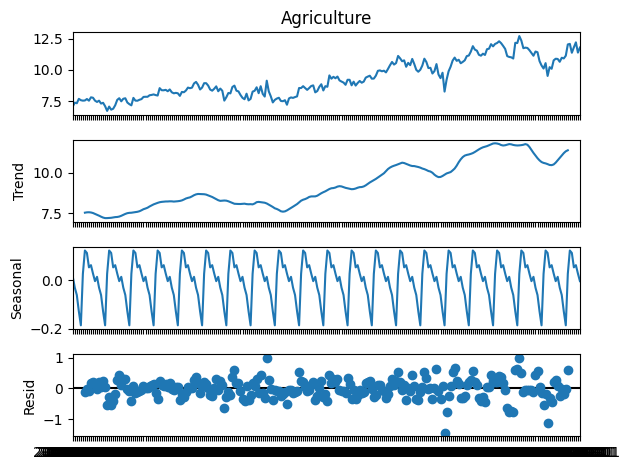

In [65]:
# Import seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
decomp = seasonal_decompose(Agriculture_MilkRiver['Agriculture'],
                            period=12)

# Plot decomposition
decomp.plot()
plt.show()

In [66]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(Agriculture_MilkRiver)
# Print test statistic
print(result)

(-1.3905081663397558, 0.5868180685930477, 1, 250, {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}, 185.58786813585323)


In [67]:
#Ho null hypostheis : It is non stationary
#H1 Alternate hypoyhesis : It is stationary

def adfuller_test(y):
    result=adfuller(y)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [68]:
adfuller_test(Agriculture_MilkRiver['Agriculture'])

ADF Test Statistic : -1.3905081663397558
p-value : 0.5868180685930477
#Lags Used : 1
Number of Observations Used : 250
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [69]:
Agriculture_MilkRiver['Agriculture-diff'] = Agriculture_MilkRiver['Agriculture'] - Agriculture_MilkRiver['Agriculture'].shift(1)

In [70]:
adfuller_test(Agriculture_MilkRiver['Agriculture-diff'].dropna())

ADF Test Statistic : -9.623959855910034
p-value : 1.6799411003445391e-16
#Lags Used : 3
Number of Observations Used : 247
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Date'>

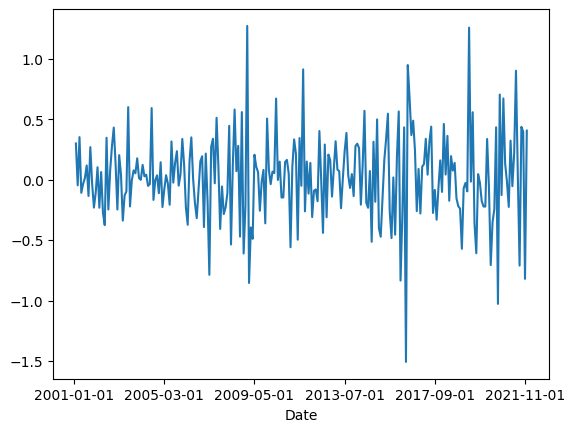

In [71]:
Agriculture_MilkRiver['Agriculture-diff'].plot()

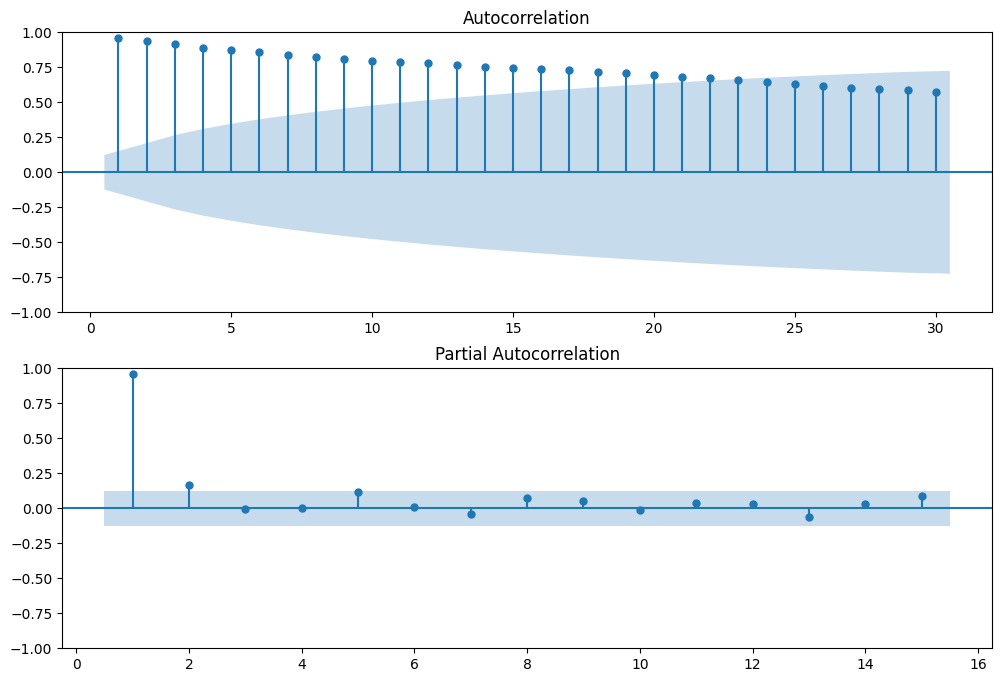

In [72]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(Agriculture_MilkRiver['Agriculture'],zero=False,lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(Agriculture_MilkRiver['Agriculture'],zero= False,lags=15,ax=ax2)


In [73]:
# Create empty list to store search results
order_aic_bic=[]
# Loop over p values from 0-2
for p in range(3):
# Loop over q values from 0-2
    for q in range(4):
        try:
            # Create and fit ARIMA(p,d,q) model
            model = sm.tsa.ARIMA(Agriculture_MilkRiver['Agriculture'], order=(p,0,q), trend='c')
            results = model.fit()
            # Append order and results tuple
            order_aic_bic.append((p,q,results.aic, results.bic))
        except:
            print(p, q, None, None)

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [74]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

    p  q         AIC         BIC
5   1  1  192.588260  206.705976
9   2  1  193.270281  210.917426
8   2  0  193.476322  207.594038
6   1  2  194.201337  211.848482
10  2  2  195.107083  216.283658
7   1  3  196.094448  217.271022
11  2  3  197.834131  222.540134
4   1  0  199.845080  210.433367
3   0  3  423.475774  441.122919
2   0  2  527.861249  541.978966
1   0  1  665.605705  676.193992
0   0  0  925.918036  932.976894
    p  q         AIC         BIC
5   1  1  192.588260  206.705976
8   2  0  193.476322  207.594038
4   1  0  199.845080  210.433367
9   2  1  193.270281  210.917426
6   1  2  194.201337  211.848482
10  2  2  195.107083  216.283658
7   1  3  196.094448  217.271022
11  2  3  197.834131  222.540134
3   0  3  423.475774  441.122919
2   0  2  527.861249  541.978966
1   0  1  665.605705  676.193992
0   0  0  925.918036  932.976894


In [75]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
model = sm.tsa.ARIMA(Agriculture_MilkRiver['Agriculture'], order=(1, 1, 1))
# Fit the model
results_ARIMAX = model.fit()

# Print model fit summary
print(results_ARIMAX.summary())

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Agriculture   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -89.871
Date:                Mon, 08 Apr 2024   AIC                            185.743
Time:                        00:49:50   BIC                            196.319
Sample:                    01-01-2001   HQIC                           189.999
                         - 12-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5794      0.149      3.898      0.000       0.288       0.871
ma.L1         -0.7651      0.115     -6.648      0.000      -0.991      -0.540
sigma2         0.1198      0.008     15.121      0.0

# Use testing data as of last six months

In [76]:
from datetime import datetime, timedelta
import pandas as pd

# Convert index to DateTimeIndex
Agriculture_MilkRiver.index = pd.to_datetime(Agriculture_MilkRiver.index)

train_dataset_end = datetime(2021, 6, 1)
test_dataset_end = datetime(2021, 12, 1)

train_data = Agriculture_MilkRiver[Agriculture_MilkRiver.index <= train_dataset_end]
test_data = Agriculture_MilkRiver[(Agriculture_MilkRiver.index > train_dataset_end) & (Agriculture_MilkRiver.index <= test_dataset_end)]


In [77]:
test_data

,Agriculture,Agriculture-diff
Date,,
2021-07-01,12.072590,0.047042
2021-08-01,11.361954,-0.710636
2021-09-01,11.798399,0.436446
2021-10-01,12.194492,0.396093
2021-11-01,11.373902,-0.820591
2021-12-01,11.778777,0.404876


In [78]:
model = sm.tsa.ARIMA(train_data['Agriculture'], order=(1, 1, 1))
results = model.fit()

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [79]:
forecast_periods = len(test_data['Agriculture'])  # Number of periods to forecast
predictions = results.forecast(steps=forecast_periods)
predictions = pd.Series(predictions, index=test_data.index)
predictions



Date
2021-07-01    11.828251
2021-08-01    11.698437
2021-09-01    11.613023
2021-10-01    11.556824
2021-11-01    11.519847
2021-12-01    11.495517
Name: predicted_mean, dtype: float64

In [80]:
residuals = test_data['Agriculture'] - predictions
residuals

Date
2021-07-01    0.244339
2021-08-01   -0.336483
2021-09-01    0.185376
2021-10-01    0.637668
2021-11-01   -0.145946
2021-12-01    0.283260
dtype: float64

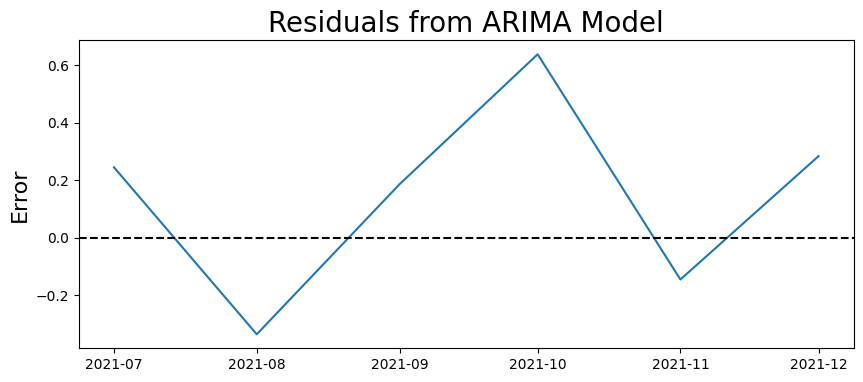

In [81]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.show()

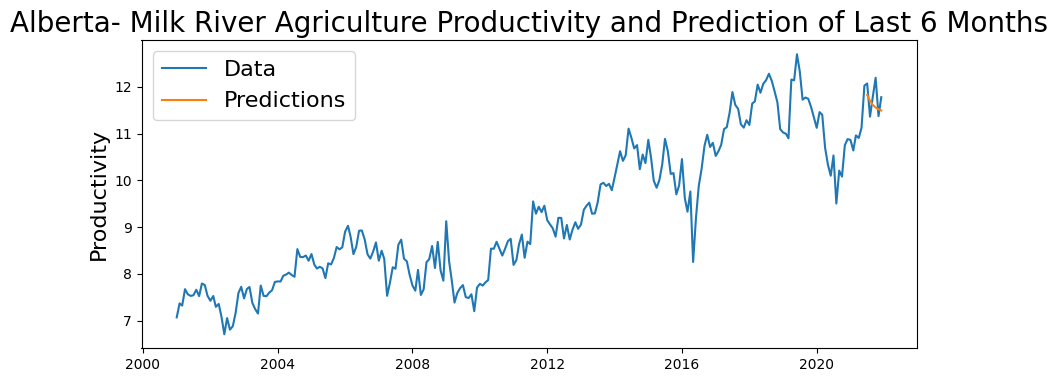

In [82]:
start_date = datetime(2021,6,1)
end_date = datetime(2021,12,1)

plt.figure(figsize=(10,4))

plt.plot(Agriculture_MilkRiver['Agriculture'])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Alberta- Milk River Agriculture Productivity and Prediction of Last 6 Months', fontsize=20)
plt.ylabel('Productivity', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [83]:
rmse = np.sqrt(np.mean(residuals**2))
print('Root Mean Squared Error:', rmse)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(residuals))
print('Mean Absolute Error:', mae)

# Calculate Mean Squared Error (MSE)
mse = np.mean(residuals**2)
print('Mean Squared Error:', mse)

Root Mean Squared Error: 0.34531233148763807
Mean Absolute Error: 0.305511933213739
Mean Squared Error: 0.11924060627742843


# SARIMA

In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

    p  q         AIC         BIC
5   1  1  192.588260  206.705976
9   2  1  193.270281  210.917426
8   2  0  193.476322  207.594038
6   1  2  194.201337  211.848482
10  2  2  195.107083  216.283658
7   1  3  196.094448  217.271022
11  2  3  197.834131  222.540134
4   1  0  199.845080  210.433367
3   0  3  423.475774  441.122919
2   0  2  527.861249  541.978966
1   0  1  665.605705  676.193992
0   0  0  925.918036  932.976894
    p  q         AIC         BIC
5   1  1  192.588260  206.705976
8   2  0  193.476322  207.594038
4   1  0  199.845080  210.433367
9   2  1  193.270281  210.917426
6   1  2  194.201337  211.848482
10  2  2  195.107083  216.283658
7   1  3  196.094448  217.271022
11  2  3  197.834131  222.540134
3   0  3  423.475774  441.122919
2   0  2  527.861249  541.978966
1   0  1  665.605705  676.193992
0   0  0  925.918036  932.976894


In [85]:
model_SARIMA=SARIMAX(Agriculture_MilkRiver['Agriculture'],order=(0,1,0),seasonal_order=(1,0,1,12))
model_SARIMA_fit=model_SARIMA.fit()
model_SARIMA_fit.summary()

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                          Agriculture   No. Observations:                  252
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 -93.720
Date:                              Mon, 08 Apr 2024   AIC                            193.440
Time:                                      00:49:52   BIC                            204.016
Sample:                                  01-01-2001   HQIC                           197.696
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8261      0.176     -4.692      0.000      -1.171      -0.481
ma.S.L12       0.9260      0.154      5.996      0.000       0.623       1.229
sigma2         0.1224      0.009     14.145      0.000       0.105       0.139
===================================================================================
Ljung-Box (L1) (Q):                   8.39   Jarque-Bera (JB):                32.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.58   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Predictions for last 6 months


In [86]:
from datetime import datetime,timedelta
train_dataset_end=datetime(2021,6,1)
test_dataset_end=datetime(2021,12,1)


train_data=Agriculture_MilkRiver[:train_dataset_end]
test_data=Agriculture_MilkRiver[train_dataset_end+timedelta(days=1):test_dataset_end]


In [87]:
#Fit SARIMA model
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data['Agriculture'].dropna(), order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit()
print(model_fit.summary())

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                          Agriculture   No. Observations:                  246
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 -86.676
Date:                              Mon, 08 Apr 2024   AIC                            179.353
Time:                                      00:49:53   BIC                            189.857
Sample:                                  01-01-2001   HQIC                           183.583
                                       - 06-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8530      0.152     -5.625      0.000      -1.150      -0.556
ma.S.L12       0.99

C:\Users\PC\anaconda3\envs\MachineLearning2\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0, 0.5, 'Error')

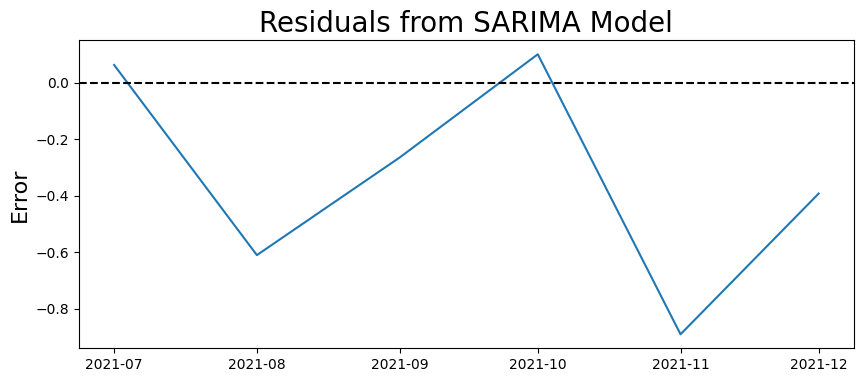

In [88]:
predictions = model_fit.forecast(steps=len(test_data['Agriculture']))
predictions = pd.Series(predictions, index=test_data.index)
predictions
residuals = test_data['Agriculture'] - predictions
residuals
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0, 0.5, 'Sales')

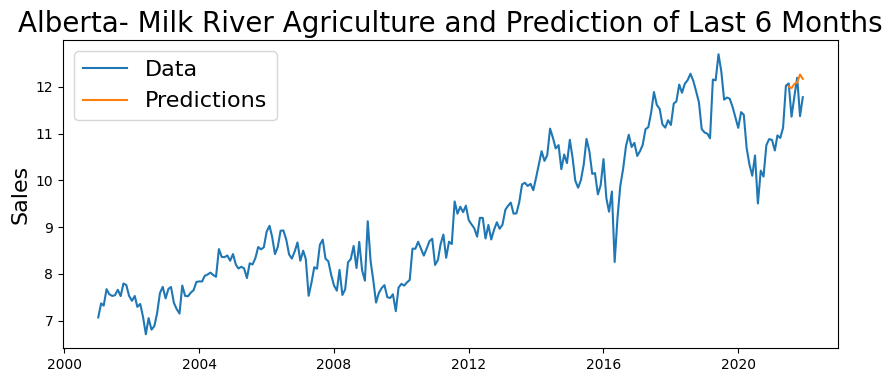

In [89]:
plt.figure(figsize=(10,4))

plt.plot(Agriculture_MilkRiver['Agriculture'])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Alberta- Milk River Agriculture and Prediction of Last 6 Months', fontsize=20)
plt.ylabel('Sales', fontsize=16)


In [90]:
rmse = np.sqrt(np.mean(residuals**2))
print('Root Mean Squared Error:', rmse)

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(residuals))
print('Mean Absolute Error:', mae)

# Calculate Mean Squared Error (MSE)
mse = np.mean(residuals**2)
print('Mean Squared Error:', mse)

Root Mean Squared Error: 0.48332048145367923
Mean Absolute Error: 0.3865458864265057
Mean Squared Error: 0.23359868779261628
